<a href="https://colab.research.google.com/github/kamilMlynarczykk/projekt-Speech-emotion-recognition/blob/main/Speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Konfiguracja Początkowa


In [ ]:
!unzip /content/drive/MyDrive/WUM/Recordings/CREMAD.zip -d /content/CREMAD
!unzip /content/drive/MyDrive/WUM/Recordings/TESS.zip -d /content/TESS
!unzip /content/drive/MyDrive/WUM/Recordings/SAVEE.zip -d /content/SAVEE
!unzip /content/drive/MyDrive/WUM/Recordings/RAVDESS.zip -d /content/RAVDESS

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_such_happy.wav  
  inflating: /content/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_sure_happy.wav  
  inflating: /content/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_take_happy.wav  
  inflating: /content/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_talk_happy.wav  
  inflating: /content/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_tape_happy.wav  
  inflating: /content/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_team_happy.wav  
  inflating: /content/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_

## 2. Wczytywanie ścieżek z folderów i zapis jako dataframe do pliku CSV


In [ ]:
import time

import pandas
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


import warnings
warnings.filterwarnings('ignore')

### Wczytanie ścieżek i etykiet następnie zapis do list

In [ ]:
# Initialize lists to store paths and labels
paths = []
labels = []

# Crema
for dirname, _, filenames in os.walk("../content/CREMAD/AudioWAV"):
    for filename in filenames:
        file_path = os.path.join(dirname, filename).replace("\\", "/")
        paths.append(file_path)
        label = filename.split('_')[-2]
        if label == "ANG":
            labels.append("angry")
        elif label == "DIS":
            labels.append("disgust")
        elif label == "FEA":
            labels.append("fear")
        elif label == "HAP":
            labels.append("happy")
        elif label == "NEU":
            labels.append("neutral")
        elif label == "SAD":
            labels.append("sad")
print('CREMA dataset is Loaded')
print(len(paths))
#TESS dataset
for dirname, _, filenames in os.walk('../content/TESS/TESS Toronto emotional speech set data'):
    for filename in filenames:
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        if label != "ps":
          paths.append(os.path.join(dirname, filename).replace("\\", "/"))
          labels.append(label.lower())

print('TESS dataset is Loaded')
print(len(paths))
## Ravdess
for dirname, _, filenames in os.walk('../content/RAVDESS/audio_speech_actors_01-24'):
    for filename in filenames:
        label = filename.split('-')[2]
        if label != "02" and label !="08":
            paths.append(os.path.join(dirname, filename).replace("\\", "/"))

        if label == "01":
            labels.append("neutral")
        elif label == "03":
            labels.append("happy")
        elif label == "04":
            labels.append("sad")
        elif label == "05":
            labels.append("angry")
        elif label == "06":
            labels.append("fear")
        elif label == "07":
            labels.append("disgust")

print('RAVDESS dataset is Loaded')
print(len(paths))
#Savee
for dirname, _, filenames in os.walk('../content/SAVEE/ALL'):
    for filename in filenames:
        label = filename.split('_')[-1][0] if filename.split('_')[-1][1].isdigit() else filename.split('_')[-1][0:2]
        if label != "su":
          paths.append(os.path.join(dirname, filename).replace("\\", "/"))

        if label == "n":
            labels.append("neutral")
        elif label == "h":
            labels.append("happy")
        elif label == "sa":
            labels.append("sad")
        elif label == "a":
            labels.append("angry")
        elif label == "f":
            labels.append("fear")
        elif label == "d":
            labels.append("disgust")

print("SAVEE dataset is loaded")
print(len(paths))

CREMA dataset is Loaded
7442
TESS dataset is Loaded
9842
RAVDESS dataset is Loaded
10898
SAVEE dataset is loaded
11318


In [ ]:
df = pd.DataFrame()
df["Speech"] = paths
df["labels"] = labels


In [ ]:
df["labels"].value_counts()

labels
sad        1923
disgust    1923
angry      1923
fear       1923
happy      1923
neutral    1703
Name: count, dtype: int64

### Zapis do pliku CSV

In [ ]:
df.to_csv("/content/drive/MyDrive/WUM/Recordings_Dataframe/data_path_WUM.csv",index=False)

## 3. Powiększanie zbioru danych poprzez filtry i ekstrakcja cech

### Wczytanie danych z pliku
Wczytanie podpisanych ścieżek audio z dysku google

In [ ]:
import timeit
import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display
import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WUM/Recordings_Dataframe/data_path_WUM.csv')

paths = df["Speech"].tolist()
labels = df["labels"].tolist()

oversampling z przefiltrowanych plikach: noise, stretch, pitch, shift

In [ ]:
def noise(y):
    noise_amp = 0.035*np.random.uniform()*np.amax(y)
    y = y + noise_amp*np.random.normal(size=y.shape[0])
    return y

def stretch(y):
  return librosa.effects.time_stretch(y,rate=0.8)

def pitch_shift(y,sr):
  return librosa.effects.pitch_shift(y=y,sr=sr,n_steps=3)

### Metody ekstrakcji cech z pliku audio

In [ ]:
# Metoda MFCC
def extract_mfcc(n, y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n,hop_length=512)
    mfccs = np.mean(mfccs.T, axis=0) # Optional: Average over time
    #print(mfccs, mfccs.shape)
    return mfccs

# Metoda Root Mean Squeare - RMS
def extract_rms(y):
    rms = librosa.feature.rms(y=y,frame_length=2048,hop_length=512)[0][:30]
    #print(rms,rms.shape)
    #rms = np.mean(rms.T, axis=0)  # Optional: Average over time
    return np.squeeze(rms)

# Metoda Chroma-STFT
def extract_chroma(n, y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma = n, hop_length=512)
    chroma = np.mean(chroma.T, axis=0)  # Optional: Average over time
    #print(chroma, chroma.shape)
    return chroma

# Metoda Zero Crossing Rate - ZCR
def extract_zcr(y):
  zcr = librosa.feature.zero_crossing_rate(y=y,frame_length=2048,hop_length=512)[0][:30]
  #zcr = np.mean(zcr.T, axis=0)
  #print(zcr,zcr.shape)
  return np.squeeze(zcr)

# Metoda Spectral Centroid
def extract_scectroid(y,sr):
  spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_centroids  # Averaging spectral centroids

# Metoda Spectral Bandtwidth
def extract_sbandwidth(y,sr):
  spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_bandwidth  # Averaging spectral centroids

# Metoda Spectral Contrast
def extract_scontrast(y,sr):
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_contrast  # Averaging spectral centroids

# Metoda Spectral Flatness
def extract_sflatness(y,sr):
  spectral_flatness = librosa.feature.spectral_flatness(y=y, n_fft=2048, hop_length=512)[0][:30]
  return spectral_flatness  # Averaging spectral centroids

# Metoda Spectral Roll-off
def extract_srolloff(y,sr):
  spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_rolloff  # Averaging spectral centroids

In [ ]:
def extract_features(y,sr, n_f_m, n_f_c):
  result = np.array([])
  mfcc = extract_mfcc(n = n_f_m, y=y, sr=sr)
  chroma = extract_chroma(n = n_f_c, y=y, sr=sr)
  zcr = extract_zcr(y=y)
  rms = extract_rms(y=y)
  sCentroid = extract_scectroid(y=y,sr=sr)
  sBandhwidth = extract_sbandwidth(y=y,sr=sr)
  sContrast = extract_scontrast(y=y,sr=sr)
  sFlatness = extract_sflatness(y=y,sr=sr)
  sRolloff = extract_srolloff(y=y,sr=sr)
  result = np.hstack((result,
                      mfcc,
                      chroma,
                      zcr,
                      rms,
                      sCentroid,
                      sBandhwidth,
                      sContrast,
                      sFlatness,
                      sRolloff
                      ))

  return result

Pętla wykonująca ekstrakcje cech

In [ ]:
number_of_features_mfcc = 42
number_of_features_chroma = 24
min_val = 25 #featuresForZCRandRMS()
start = timeit.default_timer()

i = 0
X_f = []
result = np.array([])
new_labels = []
for path in tqdm(paths):
    y, sr = librosa.load(path, duration = 2.5, offset=0.5)

    if result.size == 0: result = extract_features(y,sr,number_of_features_mfcc, number_of_features_chroma)
    else: result = np.vstack((result,extract_features(y,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

    data_noise = noise(y)
    result = np.vstack((result,
                        extract_features(data_noise,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

    data_stretch = stretch(y)
    result = np.vstack((result,
                        extract_features(data_stretch,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

    data_pitch_shift = pitch_shift(y,sr)
    result = np.vstack((result,
                        extract_features(data_pitch_shift,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

    i+=1
    if i%10==0:
      xd = np.array(result)
      print(xd.shape)

end = timeit.default_timer()
print(f"Czas pętli: {(end-start)} sekund")

X_f = np.array(result)
X_f.shape

  0%|          | 10/11318 [00:03<1:00:28,  3.12it/s]

(40, 276)


  0%|          | 20/11318 [00:07<1:05:40,  2.87it/s]

(80, 276)


  0%|          | 30/11318 [00:10<1:07:07,  2.80it/s]

(120, 276)


  0%|          | 40/11318 [00:14<1:13:30,  2.56it/s]

(160, 276)


  0%|          | 50/11318 [00:18<1:05:50,  2.85it/s]

(200, 276)


  1%|          | 60/11318 [00:22<1:09:32,  2.70it/s]

(240, 276)


  1%|          | 70/11318 [00:25<1:08:36,  2.73it/s]

(280, 276)


  1%|          | 80/11318 [00:29<1:18:51,  2.38it/s]

(320, 276)


  1%|          | 90/11318 [00:33<1:10:40,  2.65it/s]

(360, 276)


  1%|          | 100/11318 [00:37<1:12:59,  2.56it/s]

(400, 276)


  1%|          | 110/11318 [00:41<1:07:32,  2.77it/s]

(440, 276)


  1%|          | 120/11318 [00:45<1:13:30,  2.54it/s]

(480, 276)


  1%|          | 130/11318 [00:48<1:04:26,  2.89it/s]

(520, 276)


  1%|          | 140/11318 [00:52<1:13:29,  2.53it/s]

(560, 276)


  1%|▏         | 150/11318 [00:57<1:23:18,  2.23it/s]

(600, 276)


  1%|▏         | 160/11318 [01:00<1:05:21,  2.85it/s]

(640, 276)


  2%|▏         | 170/11318 [01:04<1:04:35,  2.88it/s]

(680, 276)


  2%|▏         | 180/11318 [01:08<1:09:35,  2.67it/s]

(720, 276)


  2%|▏         | 190/11318 [01:11<1:13:59,  2.51it/s]

(760, 276)


  2%|▏         | 200/11318 [01:15<1:08:55,  2.69it/s]

(800, 276)


  2%|▏         | 210/11318 [01:19<1:09:57,  2.65it/s]

(840, 276)


  2%|▏         | 220/11318 [01:22<1:08:49,  2.69it/s]

(880, 276)


  2%|▏         | 230/11318 [01:27<1:17:45,  2.38it/s]

(920, 276)


  2%|▏         | 240/11318 [01:30<1:05:11,  2.83it/s]

(960, 276)


  2%|▏         | 250/11318 [01:34<1:12:06,  2.56it/s]

(1000, 276)


  2%|▏         | 260/11318 [01:38<1:05:44,  2.80it/s]

(1040, 276)


  2%|▏         | 270/11318 [01:42<1:08:59,  2.67it/s]

(1080, 276)


  2%|▏         | 280/11318 [01:45<1:06:20,  2.77it/s]

(1120, 276)


  3%|▎         | 290/11318 [01:49<1:02:49,  2.93it/s]

(1160, 276)


  3%|▎         | 300/11318 [01:52<1:07:14,  2.73it/s]

(1200, 276)


  3%|▎         | 310/11318 [01:56<1:09:33,  2.64it/s]

(1240, 276)


  3%|▎         | 320/11318 [01:59<1:05:37,  2.79it/s]

(1280, 276)


  3%|▎         | 330/11318 [02:03<1:00:38,  3.02it/s]

(1320, 276)


  3%|▎         | 340/11318 [02:08<1:29:23,  2.05it/s]

(1360, 276)


  3%|▎         | 350/11318 [02:11<1:05:56,  2.77it/s]

(1400, 276)


  3%|▎         | 360/11318 [02:15<1:07:42,  2.70it/s]

(1440, 276)


  3%|▎         | 370/11318 [02:19<1:10:44,  2.58it/s]

(1480, 276)


  3%|▎         | 380/11318 [02:23<1:13:26,  2.48it/s]

(1520, 276)


  3%|▎         | 390/11318 [02:26<59:44,  3.05it/s]  

(1560, 276)


  4%|▎         | 400/11318 [02:30<1:05:43,  2.77it/s]

(1600, 276)


  4%|▎         | 410/11318 [02:34<1:17:21,  2.35it/s]

(1640, 276)


  4%|▎         | 420/11318 [02:38<1:07:39,  2.68it/s]

(1680, 276)


  4%|▍         | 430/11318 [02:42<1:04:36,  2.81it/s]

(1720, 276)


  4%|▍         | 440/11318 [02:45<1:07:07,  2.70it/s]

(1760, 276)


  4%|▍         | 450/11318 [02:49<1:08:29,  2.64it/s]

(1800, 276)


  4%|▍         | 460/11318 [02:53<1:05:04,  2.78it/s]

(1840, 276)


  4%|▍         | 470/11318 [02:56<1:04:19,  2.81it/s]

(1880, 276)


  4%|▍         | 480/11318 [03:00<1:11:21,  2.53it/s]

(1920, 276)


  4%|▍         | 490/11318 [03:05<1:24:00,  2.15it/s]

(1960, 276)


  4%|▍         | 500/11318 [03:09<1:12:25,  2.49it/s]

(2000, 276)


  5%|▍         | 510/11318 [03:13<1:10:43,  2.55it/s]

(2040, 276)


  5%|▍         | 520/11318 [03:17<1:11:22,  2.52it/s]

(2080, 276)


  5%|▍         | 530/11318 [03:20<1:05:39,  2.74it/s]

(2120, 276)


  5%|▍         | 540/11318 [03:24<1:13:42,  2.44it/s]

(2160, 276)


  5%|▍         | 550/11318 [03:28<1:06:51,  2.68it/s]

(2200, 276)


  5%|▍         | 560/11318 [03:32<1:12:03,  2.49it/s]

(2240, 276)


  5%|▌         | 570/11318 [03:36<1:09:26,  2.58it/s]

(2280, 276)


  5%|▌         | 580/11318 [03:39<1:04:02,  2.79it/s]

(2320, 276)


  5%|▌         | 590/11318 [03:43<1:08:21,  2.62it/s]

(2360, 276)


  5%|▌         | 600/11318 [03:46<58:33,  3.05it/s]  

(2400, 276)


  5%|▌         | 610/11318 [03:50<1:11:56,  2.48it/s]

(2440, 276)


  5%|▌         | 620/11318 [03:54<1:11:16,  2.50it/s]

(2480, 276)


  6%|▌         | 630/11318 [03:59<1:26:07,  2.07it/s]

(2520, 276)


  6%|▌         | 640/11318 [04:03<1:11:09,  2.50it/s]

(2560, 276)


  6%|▌         | 650/11318 [04:07<1:09:39,  2.55it/s]

(2600, 276)


  6%|▌         | 660/11318 [04:10<1:08:17,  2.60it/s]

(2640, 276)


  6%|▌         | 670/11318 [04:15<1:07:22,  2.63it/s]

(2680, 276)


  6%|▌         | 680/11318 [04:18<1:07:21,  2.63it/s]

(2720, 276)


  6%|▌         | 690/11318 [04:22<1:08:29,  2.59it/s]

(2760, 276)


  6%|▌         | 700/11318 [04:26<1:06:51,  2.65it/s]

(2800, 276)


  6%|▋         | 710/11318 [04:30<1:16:55,  2.30it/s]

(2840, 276)


  6%|▋         | 720/11318 [04:34<1:04:44,  2.73it/s]

(2880, 276)


  6%|▋         | 730/11318 [04:38<1:06:25,  2.66it/s]

(2920, 276)


  7%|▋         | 740/11318 [04:41<58:18,  3.02it/s]

(2960, 276)


  7%|▋         | 750/11318 [04:45<1:07:42,  2.60it/s]

(3000, 276)


  7%|▋         | 760/11318 [04:49<1:02:36,  2.81it/s]

(3040, 276)


  7%|▋         | 770/11318 [04:52<1:02:39,  2.81it/s]

(3080, 276)


  7%|▋         | 780/11318 [04:57<1:15:10,  2.34it/s]

(3120, 276)


  7%|▋         | 790/11318 [05:00<1:12:54,  2.41it/s]

(3160, 276)


  7%|▋         | 800/11318 [05:04<1:02:07,  2.82it/s]

(3200, 276)


  7%|▋         | 810/11318 [05:08<1:01:15,  2.86it/s]

(3240, 276)


  7%|▋         | 820/11318 [05:12<1:08:08,  2.57it/s]

(3280, 276)


  7%|▋         | 830/11318 [05:15<1:03:30,  2.75it/s]

(3320, 276)


  7%|▋         | 840/11318 [05:19<58:03,  3.01it/s]

(3360, 276)


  8%|▊         | 850/11318 [05:23<1:05:00,  2.68it/s]

(3400, 276)


  8%|▊         | 860/11318 [05:27<1:06:05,  2.64it/s]

(3440, 276)


  8%|▊         | 870/11318 [05:30<55:54,  3.11it/s]

(3480, 276)


  8%|▊         | 880/11318 [05:34<1:08:29,  2.54it/s]

(3520, 276)


  8%|▊         | 890/11318 [05:38<1:13:37,  2.36it/s]

(3560, 276)


  8%|▊         | 900/11318 [05:42<1:01:28,  2.82it/s]

(3600, 276)


  8%|▊         | 910/11318 [05:45<59:11,  2.93it/s]  

(3640, 276)


  8%|▊         | 920/11318 [05:49<1:15:26,  2.30it/s]

(3680, 276)


  8%|▊         | 930/11318 [05:54<1:13:08,  2.37it/s]

(3720, 276)


  8%|▊         | 940/11318 [05:58<1:08:34,  2.52it/s]

(3760, 276)


  8%|▊         | 950/11318 [06:02<1:11:17,  2.42it/s]

(3800, 276)


  8%|▊         | 960/11318 [06:06<1:13:46,  2.34it/s]

(3840, 276)


  9%|▊         | 970/11318 [06:10<1:09:18,  2.49it/s]

(3880, 276)


  9%|▊         | 980/11318 [06:14<1:04:13,  2.68it/s]

(3920, 276)


  9%|▊         | 990/11318 [06:18<1:05:15,  2.64it/s]

(3960, 276)


  9%|▉         | 1000/11318 [06:22<1:09:57,  2.46it/s]

(4000, 276)


  9%|▉         | 1010/11318 [06:26<1:00:00,  2.86it/s]

(4040, 276)


  9%|▉         | 1020/11318 [06:30<1:06:32,  2.58it/s]

(4080, 276)


  9%|▉         | 1030/11318 [06:34<1:09:14,  2.48it/s]

(4120, 276)


  9%|▉         | 1040/11318 [06:37<58:31,  2.93it/s]

(4160, 276)


  9%|▉         | 1050/11318 [06:41<1:07:11,  2.55it/s]

(4200, 276)


  9%|▉         | 1060/11318 [06:45<1:14:53,  2.28it/s]

(4240, 276)


  9%|▉         | 1070/11318 [06:50<1:09:03,  2.47it/s]

(4280, 276)


 10%|▉         | 1080/11318 [06:53<1:03:44,  2.68it/s]

(4320, 276)


 10%|▉         | 1090/11318 [06:57<1:03:03,  2.70it/s]

(4360, 276)


 10%|▉         | 1100/11318 [07:01<1:13:38,  2.31it/s]

(4400, 276)


 10%|▉         | 1110/11318 [07:05<1:09:51,  2.44it/s]

(4440, 276)


 10%|▉         | 1120/11318 [07:09<1:08:05,  2.50it/s]

(4480, 276)


 10%|▉         | 1130/11318 [07:13<1:07:27,  2.52it/s]

(4520, 276)


 10%|█         | 1140/11318 [07:17<1:04:16,  2.64it/s]

(4560, 276)


 10%|█         | 1150/11318 [07:20<1:05:18,  2.60it/s]

(4600, 276)


 10%|█         | 1160/11318 [07:24<1:00:34,  2.79it/s]

(4640, 276)


 10%|█         | 1170/11318 [07:28<1:21:21,  2.08it/s]

(4680, 276)


 10%|█         | 1180/11318 [07:32<1:06:25,  2.54it/s]

(4720, 276)


 11%|█         | 1190/11318 [07:36<58:26,  2.89it/s]

(4760, 276)


 11%|█         | 1200/11318 [07:40<57:12,  2.95it/s]  

(4800, 276)


 11%|█         | 1210/11318 [07:44<1:15:01,  2.25it/s]

(4840, 276)


 11%|█         | 1220/11318 [07:48<50:11,  3.35it/s]

(4880, 276)


 11%|█         | 1230/11318 [07:51<1:03:35,  2.64it/s]

(4920, 276)


 11%|█         | 1240/11318 [07:56<1:12:18,  2.32it/s]

(4960, 276)


 11%|█         | 1250/11318 [08:00<1:10:08,  2.39it/s]

(5000, 276)


 11%|█         | 1260/11318 [08:04<1:01:57,  2.71it/s]

(5040, 276)


 11%|█         | 1270/11318 [08:07<1:01:12,  2.74it/s]

(5080, 276)


 11%|█▏        | 1280/11318 [08:11<57:03,  2.93it/s]

(5120, 276)


 11%|█▏        | 1290/11318 [08:14<56:36,  2.95it/s]

(5160, 276)


 11%|█▏        | 1300/11318 [08:18<1:02:54,  2.65it/s]

(5200, 276)


 12%|█▏        | 1310/11318 [08:22<1:03:12,  2.64it/s]

(5240, 276)


 12%|█▏        | 1320/11318 [08:26<1:03:23,  2.63it/s]

(5280, 276)


 12%|█▏        | 1330/11318 [08:29<1:00:31,  2.75it/s]

(5320, 276)


 12%|█▏        | 1340/11318 [08:33<1:03:35,  2.62it/s]

(5360, 276)


 12%|█▏        | 1350/11318 [08:37<1:00:05,  2.76it/s]

(5400, 276)


 12%|█▏        | 1360/11318 [08:41<1:02:43,  2.65it/s]

(5440, 276)


 12%|█▏        | 1370/11318 [08:45<1:15:46,  2.19it/s]

(5480, 276)


 12%|█▏        | 1380/11318 [08:49<1:04:29,  2.57it/s]

(5520, 276)


 12%|█▏        | 1390/11318 [08:53<1:07:06,  2.47it/s]

(5560, 276)


 12%|█▏        | 1400/11318 [08:58<1:08:47,  2.40it/s]

(5600, 276)


 12%|█▏        | 1410/11318 [09:02<1:10:32,  2.34it/s]

(5640, 276)


 13%|█▎        | 1420/11318 [09:05<1:01:57,  2.66it/s]

(5680, 276)


 13%|█▎        | 1430/11318 [09:10<1:07:35,  2.44it/s]

(5720, 276)


 13%|█▎        | 1440/11318 [09:13<1:05:37,  2.51it/s]

(5760, 276)


 13%|█▎        | 1450/11318 [09:18<1:02:45,  2.62it/s]

(5800, 276)


 13%|█▎        | 1460/11318 [09:22<1:05:39,  2.50it/s]

(5840, 276)


 13%|█▎        | 1470/11318 [09:25<1:01:22,  2.67it/s]

(5880, 276)


 13%|█▎        | 1480/11318 [09:29<1:09:43,  2.35it/s]

(5920, 276)


 13%|█▎        | 1490/11318 [09:33<1:08:10,  2.40it/s]

(5960, 276)


 13%|█▎        | 1500/11318 [09:38<1:05:01,  2.52it/s]

(6000, 276)


 13%|█▎        | 1510/11318 [09:41<1:00:48,  2.69it/s]

(6040, 276)


 13%|█▎        | 1520/11318 [09:45<1:02:53,  2.60it/s]

(6080, 276)


 14%|█▎        | 1530/11318 [09:49<1:00:11,  2.71it/s]

(6120, 276)


 14%|█▎        | 1540/11318 [09:53<1:00:44,  2.68it/s]

(6160, 276)


 14%|█▎        | 1550/11318 [09:57<1:00:52,  2.67it/s]

(6200, 276)


 14%|█▍        | 1560/11318 [10:00<1:02:40,  2.59it/s]

(6240, 276)


 14%|█▍        | 1570/11318 [10:05<1:09:42,  2.33it/s]

(6280, 276)


 14%|█▍        | 1580/11318 [10:08<54:48,  2.96it/s]

(6320, 276)


 14%|█▍        | 1590/11318 [10:12<1:04:39,  2.51it/s]

(6360, 276)


 14%|█▍        | 1600/11318 [10:16<1:02:07,  2.61it/s]

(6400, 276)


 14%|█▍        | 1610/11318 [10:20<1:04:04,  2.52it/s]

(6440, 276)


 14%|█▍        | 1620/11318 [10:24<1:03:01,  2.56it/s]

(6480, 276)


 14%|█▍        | 1630/11318 [10:28<1:01:54,  2.61it/s]

(6520, 276)


 14%|█▍        | 1640/11318 [10:32<1:06:31,  2.42it/s]

(6560, 276)


 15%|█▍        | 1650/11318 [10:35<1:00:06,  2.68it/s]

(6600, 276)


 15%|█▍        | 1660/11318 [10:39<1:00:37,  2.66it/s]

(6640, 276)


 15%|█▍        | 1670/11318 [10:43<1:04:21,  2.50it/s]

(6680, 276)


 15%|█▍        | 1680/11318 [10:47<1:17:31,  2.07it/s]

(6720, 276)


 15%|█▍        | 1690/11318 [10:51<1:08:17,  2.35it/s]

(6760, 276)


 15%|█▌        | 1700/11318 [10:55<57:33,  2.78it/s]

(6800, 276)


 15%|█▌        | 1710/11318 [10:59<1:12:32,  2.21it/s]

(6840, 276)


 15%|█▌        | 1720/11318 [11:04<1:07:13,  2.38it/s]

(6880, 276)


 15%|█▌        | 1730/11318 [11:08<1:00:05,  2.66it/s]

(6920, 276)


 15%|█▌        | 1740/11318 [11:12<1:06:45,  2.39it/s]

(6960, 276)


 15%|█▌        | 1750/11318 [11:16<1:09:39,  2.29it/s]

(7000, 276)


 16%|█▌        | 1760/11318 [11:20<1:07:20,  2.37it/s]

(7040, 276)


 16%|█▌        | 1770/11318 [11:24<1:02:04,  2.56it/s]

(7080, 276)


 16%|█▌        | 1780/11318 [11:28<1:11:16,  2.23it/s]

(7120, 276)


 16%|█▌        | 1790/11318 [11:32<1:02:16,  2.55it/s]

(7160, 276)


 16%|█▌        | 1800/11318 [11:36<55:45,  2.84it/s]

(7200, 276)


 16%|█▌        | 1810/11318 [11:40<1:08:33,  2.31it/s]

(7240, 276)


 16%|█▌        | 1820/11318 [11:44<1:05:08,  2.43it/s]

(7280, 276)


 16%|█▌        | 1830/11318 [11:48<1:07:12,  2.35it/s]

(7320, 276)


 16%|█▋        | 1840/11318 [11:52<1:00:03,  2.63it/s]

(7360, 276)


 16%|█▋        | 1850/11318 [11:57<1:09:11,  2.28it/s]

(7400, 276)


 16%|█▋        | 1860/11318 [12:00<59:49,  2.63it/s]

(7440, 276)


 17%|█▋        | 1870/11318 [12:04<58:35,  2.69it/s]  

(7480, 276)


 17%|█▋        | 1880/11318 [12:08<1:08:08,  2.31it/s]

(7520, 276)


 17%|█▋        | 1890/11318 [12:13<1:01:25,  2.56it/s]

(7560, 276)


 17%|█▋        | 1900/11318 [12:16<57:44,  2.72it/s]

(7600, 276)


 17%|█▋        | 1910/11318 [12:20<55:34,  2.82it/s]

(7640, 276)


 17%|█▋        | 1920/11318 [12:24<1:08:14,  2.30it/s]

(7680, 276)


 17%|█▋        | 1930/11318 [12:28<58:49,  2.66it/s]

(7720, 276)


 17%|█▋        | 1940/11318 [12:32<1:01:16,  2.55it/s]

(7760, 276)


 17%|█▋        | 1950/11318 [12:36<1:00:59,  2.56it/s]

(7800, 276)


 17%|█▋        | 1960/11318 [12:40<1:08:13,  2.29it/s]

(7840, 276)


 17%|█▋        | 1970/11318 [12:44<58:03,  2.68it/s]

(7880, 276)


 17%|█▋        | 1980/11318 [12:48<56:45,  2.74it/s]

(7920, 276)


 18%|█▊        | 1990/11318 [12:52<1:02:41,  2.48it/s]

(7960, 276)


 18%|█▊        | 2000/11318 [12:56<1:02:55,  2.47it/s]

(8000, 276)


 18%|█▊        | 2010/11318 [13:00<58:49,  2.64it/s]

(8040, 276)


 18%|█▊        | 2020/11318 [13:04<1:10:23,  2.20it/s]

(8080, 276)


 18%|█▊        | 2030/11318 [13:09<1:11:05,  2.18it/s]

(8120, 276)


 18%|█▊        | 2040/11318 [13:13<1:00:57,  2.54it/s]

(8160, 276)


 18%|█▊        | 2050/11318 [13:16<56:04,  2.75it/s]

(8200, 276)


 18%|█▊        | 2060/11318 [13:21<1:04:12,  2.40it/s]

(8240, 276)


 18%|█▊        | 2070/11318 [13:25<1:01:10,  2.52it/s]

(8280, 276)


 18%|█▊        | 2080/11318 [13:28<1:02:28,  2.46it/s]

(8320, 276)


 18%|█▊        | 2090/11318 [13:32<59:56,  2.57it/s]

(8360, 276)


 19%|█▊        | 2100/11318 [13:36<1:03:08,  2.43it/s]

(8400, 276)


 19%|█▊        | 2110/11318 [13:40<1:03:38,  2.41it/s]

(8440, 276)


 19%|█▊        | 2120/11318 [13:44<1:02:51,  2.44it/s]

(8480, 276)


 19%|█▉        | 2130/11318 [13:49<1:06:51,  2.29it/s]

(8520, 276)


 19%|█▉        | 2140/11318 [13:53<55:39,  2.75it/s]

(8560, 276)


 19%|█▉        | 2150/11318 [13:57<1:01:43,  2.48it/s]

(8600, 276)


 19%|█▉        | 2160/11318 [14:01<1:08:46,  2.22it/s]

(8640, 276)


 19%|█▉        | 2170/11318 [14:05<1:06:41,  2.29it/s]

(8680, 276)


 19%|█▉        | 2180/11318 [14:09<1:01:10,  2.49it/s]

(8720, 276)


 19%|█▉        | 2190/11318 [14:13<58:24,  2.60it/s]  

(8760, 276)


 19%|█▉        | 2200/11318 [14:18<1:01:31,  2.47it/s]

(8800, 276)


 20%|█▉        | 2210/11318 [14:21<58:55,  2.58it/s]

(8840, 276)


 20%|█▉        | 2220/11318 [14:25<53:07,  2.85it/s]

(8880, 276)


 20%|█▉        | 2230/11318 [14:29<1:07:24,  2.25it/s]

(8920, 276)


 20%|█▉        | 2240/11318 [14:33<1:02:26,  2.42it/s]

(8960, 276)


 20%|█▉        | 2250/11318 [14:37<1:02:31,  2.42it/s]

(9000, 276)


 20%|█▉        | 2260/11318 [14:41<1:00:07,  2.51it/s]

(9040, 276)


 20%|██        | 2270/11318 [14:46<1:04:01,  2.36it/s]

(9080, 276)


 20%|██        | 2280/11318 [14:50<59:33,  2.53it/s]

(9120, 276)


 20%|██        | 2290/11318 [14:54<59:08,  2.54it/s]  

(9160, 276)


 20%|██        | 2300/11318 [14:58<1:05:14,  2.30it/s]

(9200, 276)


 20%|██        | 2310/11318 [15:02<59:35,  2.52it/s]

(9240, 276)


 20%|██        | 2320/11318 [15:06<1:03:42,  2.35it/s]

(9280, 276)


 21%|██        | 2330/11318 [15:09<52:38,  2.85it/s]

(9320, 276)


 21%|██        | 2340/11318 [15:14<1:07:42,  2.21it/s]

(9360, 276)


 21%|██        | 2350/11318 [15:17<57:32,  2.60it/s]

(9400, 276)


 21%|██        | 2360/11318 [15:21<57:55,  2.58it/s]

(9440, 276)


 21%|██        | 2370/11318 [15:25<1:05:41,  2.27it/s]

(9480, 276)


 21%|██        | 2380/11318 [15:29<57:47,  2.58it/s]

(9520, 276)


 21%|██        | 2390/11318 [15:33<56:43,  2.62it/s]

(9560, 276)


 21%|██        | 2400/11318 [15:37<58:46,  2.53it/s]

(9600, 276)


 21%|██▏       | 2410/11318 [15:41<1:07:33,  2.20it/s]

(9640, 276)


 21%|██▏       | 2420/11318 [15:45<56:22,  2.63it/s]

(9680, 276)


 21%|██▏       | 2430/11318 [15:49<57:12,  2.59it/s]

(9720, 276)


 22%|██▏       | 2440/11318 [15:53<1:03:54,  2.32it/s]

(9760, 276)


 22%|██▏       | 2450/11318 [15:57<56:15,  2.63it/s]

(9800, 276)


 22%|██▏       | 2460/11318 [16:01<54:52,  2.69it/s]

(9840, 276)


 22%|██▏       | 2470/11318 [16:05<59:01,  2.50it/s]  

(9880, 276)


 22%|██▏       | 2480/11318 [16:09<1:03:50,  2.31it/s]

(9920, 276)


 22%|██▏       | 2490/11318 [16:13<57:55,  2.54it/s]  

(9960, 276)


 22%|██▏       | 2500/11318 [16:18<1:03:04,  2.33it/s]

(10000, 276)


 22%|██▏       | 2510/11318 [16:22<1:00:49,  2.41it/s]

(10040, 276)


 22%|██▏       | 2520/11318 [16:25<55:35,  2.64it/s]

(10080, 276)


 22%|██▏       | 2530/11318 [16:29<1:02:17,  2.35it/s]

(10120, 276)


 22%|██▏       | 2540/11318 [16:33<55:28,  2.64it/s]

(10160, 276)


 23%|██▎       | 2550/11318 [16:38<1:10:52,  2.06it/s]

(10200, 276)


 23%|██▎       | 2560/11318 [16:42<53:10,  2.75it/s]

(10240, 276)


 23%|██▎       | 2570/11318 [16:45<58:04,  2.51it/s]

(10280, 276)


 23%|██▎       | 2580/11318 [16:50<1:09:55,  2.08it/s]

(10320, 276)


 23%|██▎       | 2590/11318 [16:54<59:32,  2.44it/s]  

(10360, 276)


 23%|██▎       | 2600/11318 [16:58<1:04:33,  2.25it/s]

(10400, 276)


 23%|██▎       | 2610/11318 [17:02<56:41,  2.56it/s]

(10440, 276)


 23%|██▎       | 2620/11318 [17:06<1:03:31,  2.28it/s]

(10480, 276)


 23%|██▎       | 2630/11318 [17:11<1:01:42,  2.35it/s]

(10520, 276)


 23%|██▎       | 2640/11318 [17:15<1:04:46,  2.23it/s]

(10560, 276)


 23%|██▎       | 2650/11318 [17:20<1:03:16,  2.28it/s]

(10600, 276)


 24%|██▎       | 2660/11318 [17:24<59:06,  2.44it/s]  

(10640, 276)


 24%|██▎       | 2670/11318 [17:28<1:06:08,  2.18it/s]

(10680, 276)


 24%|██▎       | 2680/11318 [17:33<1:02:47,  2.29it/s]

(10720, 276)


 24%|██▍       | 2690/11318 [17:37<58:01,  2.48it/s]

(10760, 276)


 24%|██▍       | 2700/11318 [17:41<52:34,  2.73it/s]

(10800, 276)


 24%|██▍       | 2710/11318 [17:45<56:00,  2.56it/s]

(10840, 276)


 24%|██▍       | 2720/11318 [17:49<59:10,  2.42it/s]  

(10880, 276)


 24%|██▍       | 2730/11318 [17:53<1:00:08,  2.38it/s]

(10920, 276)


 24%|██▍       | 2740/11318 [17:57<57:50,  2.47it/s]

(10960, 276)


 24%|██▍       | 2750/11318 [18:01<1:01:07,  2.34it/s]

(11000, 276)


 24%|██▍       | 2760/11318 [18:05<56:11,  2.54it/s]

(11040, 276)


 24%|██▍       | 2770/11318 [18:09<1:01:33,  2.31it/s]

(11080, 276)


 25%|██▍       | 2780/11318 [18:13<55:25,  2.57it/s]

(11120, 276)


 25%|██▍       | 2790/11318 [18:18<1:02:58,  2.26it/s]

(11160, 276)


 25%|██▍       | 2800/11318 [18:22<50:15,  2.83it/s]

(11200, 276)


 25%|██▍       | 2810/11318 [18:26<55:14,  2.57it/s]

(11240, 276)


 25%|██▍       | 2820/11318 [18:30<54:00,  2.62it/s]

(11280, 276)


 25%|██▌       | 2830/11318 [18:34<51:08,  2.77it/s]

(11320, 276)


 25%|██▌       | 2840/11318 [18:38<59:57,  2.36it/s]

(11360, 276)


 25%|██▌       | 2850/11318 [18:42<57:43,  2.44it/s]

(11400, 276)


 25%|██▌       | 2860/11318 [18:46<56:36,  2.49it/s]  

(11440, 276)


 25%|██▌       | 2870/11318 [18:50<56:42,  2.48it/s]

(11480, 276)


 25%|██▌       | 2880/11318 [18:54<56:03,  2.51it/s]

(11520, 276)


 26%|██▌       | 2890/11318 [18:59<1:10:27,  1.99it/s]

(11560, 276)


 26%|██▌       | 2900/11318 [19:03<54:25,  2.58it/s]

(11600, 276)


 26%|██▌       | 2910/11318 [19:07<1:01:55,  2.26it/s]

(11640, 276)


 26%|██▌       | 2920/11318 [19:11<57:33,  2.43it/s]

(11680, 276)


 26%|██▌       | 2930/11318 [19:15<59:09,  2.36it/s]

(11720, 276)


 26%|██▌       | 2940/11318 [19:19<50:44,  2.75it/s]

(11760, 276)


 26%|██▌       | 2950/11318 [19:23<1:00:30,  2.31it/s]

(11800, 276)


 26%|██▌       | 2960/11318 [19:27<58:18,  2.39it/s]  

(11840, 276)


 26%|██▌       | 2970/11318 [19:32<55:43,  2.50it/s]

(11880, 276)


 26%|██▋       | 2980/11318 [19:36<1:01:27,  2.26it/s]

(11920, 276)


 26%|██▋       | 2990/11318 [19:41<1:07:54,  2.04it/s]

(11960, 276)


 27%|██▋       | 3000/11318 [19:45<55:33,  2.50it/s]

(12000, 276)


 27%|██▋       | 3010/11318 [19:49<59:15,  2.34it/s]

(12040, 276)


 27%|██▋       | 3020/11318 [19:53<55:50,  2.48it/s]

(12080, 276)


 27%|██▋       | 3030/11318 [19:57<50:50,  2.72it/s]

(12120, 276)


 27%|██▋       | 3040/11318 [20:01<58:05,  2.38it/s]

(12160, 276)


 27%|██▋       | 3050/11318 [20:06<1:02:58,  2.19it/s]

(12200, 276)


 27%|██▋       | 3060/11318 [20:10<1:02:30,  2.20it/s]

(12240, 276)


 27%|██▋       | 3070/11318 [20:15<1:04:01,  2.15it/s]

(12280, 276)


 27%|██▋       | 3080/11318 [20:19<1:02:19,  2.20it/s]

(12320, 276)


 27%|██▋       | 3090/11318 [20:23<56:17,  2.44it/s]

(12360, 276)


 27%|██▋       | 3100/11318 [20:27<52:43,  2.60it/s]

(12400, 276)


 27%|██▋       | 3110/11318 [20:31<56:03,  2.44it/s]

(12440, 276)


 28%|██▊       | 3120/11318 [20:36<55:27,  2.46it/s]

(12480, 276)


 28%|██▊       | 3130/11318 [20:40<52:47,  2.58it/s]

(12520, 276)


 28%|██▊       | 3140/11318 [20:44<50:25,  2.70it/s]

(12560, 276)


 28%|██▊       | 3150/11318 [20:48<1:00:16,  2.26it/s]

(12600, 276)


 28%|██▊       | 3160/11318 [20:52<55:59,  2.43it/s]

(12640, 276)


 28%|██▊       | 3170/11318 [20:57<54:19,  2.50it/s]

(12680, 276)


 28%|██▊       | 3180/11318 [21:01<53:32,  2.53it/s]

(12720, 276)


 28%|██▊       | 3190/11318 [21:05<55:12,  2.45it/s]

(12760, 276)


 28%|██▊       | 3200/11318 [21:09<59:08,  2.29it/s]

(12800, 276)


 28%|██▊       | 3210/11318 [21:13<55:46,  2.42it/s]

(12840, 276)


 28%|██▊       | 3220/11318 [21:17<55:55,  2.41it/s]

(12880, 276)


 29%|██▊       | 3230/11318 [21:22<58:49,  2.29it/s]  

(12920, 276)


 29%|██▊       | 3240/11318 [21:26<1:02:02,  2.17it/s]

(12960, 276)


 29%|██▊       | 3250/11318 [21:30<58:15,  2.31it/s]

(13000, 276)


 29%|██▉       | 3260/11318 [21:34<56:15,  2.39it/s]

(13040, 276)


 29%|██▉       | 3270/11318 [21:38<54:50,  2.45it/s]

(13080, 276)


 29%|██▉       | 3280/11318 [21:43<57:00,  2.35it/s]

(13120, 276)


 29%|██▉       | 3290/11318 [21:48<1:04:50,  2.06it/s]

(13160, 276)


 29%|██▉       | 3300/11318 [21:52<54:41,  2.44it/s]

(13200, 276)


 29%|██▉       | 3310/11318 [21:56<57:01,  2.34it/s]

(13240, 276)


 29%|██▉       | 3320/11318 [22:01<1:06:16,  2.01it/s]

(13280, 276)


 29%|██▉       | 3330/11318 [22:05<57:18,  2.32it/s]

(13320, 276)


 30%|██▉       | 3340/11318 [22:09<57:10,  2.33it/s]

(13360, 276)


 30%|██▉       | 3350/11318 [22:14<1:02:52,  2.11it/s]

(13400, 276)


 30%|██▉       | 3360/11318 [22:18<54:22,  2.44it/s]

(13440, 276)


 30%|██▉       | 3370/11318 [22:22<55:46,  2.37it/s]

(13480, 276)


 30%|██▉       | 3380/11318 [22:27<1:05:22,  2.02it/s]

(13520, 276)


 30%|██▉       | 3390/11318 [22:31<1:02:38,  2.11it/s]

(13560, 276)


 30%|███       | 3400/11318 [22:36<56:34,  2.33it/s]

(13600, 276)


 30%|███       | 3410/11318 [22:40<1:00:04,  2.19it/s]

(13640, 276)


 30%|███       | 3420/11318 [22:44<58:45,  2.24it/s]

(13680, 276)


 30%|███       | 3430/11318 [22:48<54:45,  2.40it/s]

(13720, 276)


 30%|███       | 3440/11318 [22:52<51:46,  2.54it/s]

(13760, 276)


 30%|███       | 3450/11318 [22:57<1:00:39,  2.16it/s]

(13800, 276)


 31%|███       | 3460/11318 [23:01<49:53,  2.63it/s]

(13840, 276)


 31%|███       | 3470/11318 [23:05<54:03,  2.42it/s]

(13880, 276)


 31%|███       | 3480/11318 [23:09<56:11,  2.32it/s]

(13920, 276)


 31%|███       | 3490/11318 [23:13<52:42,  2.48it/s]

(13960, 276)


 31%|███       | 3500/11318 [23:17<52:33,  2.48it/s]

(14000, 276)


 31%|███       | 3510/11318 [23:22<51:51,  2.51it/s]

(14040, 276)


 31%|███       | 3520/11318 [23:26<53:32,  2.43it/s]

(14080, 276)


 31%|███       | 3530/11318 [23:30<56:58,  2.28it/s]

(14120, 276)


 31%|███▏      | 3540/11318 [23:34<52:06,  2.49it/s]

(14160, 276)


 31%|███▏      | 3550/11318 [23:38<56:44,  2.28it/s]

(14200, 276)


 31%|███▏      | 3560/11318 [23:43<54:40,  2.36it/s]

(14240, 276)


 32%|███▏      | 3570/11318 [23:47<55:39,  2.32it/s]

(14280, 276)


 32%|███▏      | 3580/11318 [23:51<59:43,  2.16it/s]

(14320, 276)


 32%|███▏      | 3590/11318 [23:55<53:20,  2.41it/s]

(14360, 276)


 32%|███▏      | 3600/11318 [23:59<55:33,  2.32it/s]

(14400, 276)


 32%|███▏      | 3610/11318 [24:03<53:21,  2.41it/s]

(14440, 276)


 32%|███▏      | 3620/11318 [24:08<1:01:21,  2.09it/s]

(14480, 276)


 32%|███▏      | 3630/11318 [24:12<54:08,  2.37it/s]

(14520, 276)


 32%|███▏      | 3640/11318 [24:16<54:49,  2.33it/s]

(14560, 276)


 32%|███▏      | 3650/11318 [24:21<59:29,  2.15it/s]

(14600, 276)


 32%|███▏      | 3660/11318 [24:25<53:00,  2.41it/s]

(14640, 276)


 32%|███▏      | 3670/11318 [24:29<58:40,  2.17it/s]

(14680, 276)


 33%|███▎      | 3680/11318 [24:34<55:41,  2.29it/s]

(14720, 276)


 33%|███▎      | 3690/11318 [24:38<55:41,  2.28it/s]

(14760, 276)


 33%|███▎      | 3700/11318 [24:42<56:41,  2.24it/s]

(14800, 276)


 33%|███▎      | 3710/11318 [24:47<56:55,  2.23it/s]

(14840, 276)


 33%|███▎      | 3720/11318 [24:51<54:30,  2.32it/s]

(14880, 276)


 33%|███▎      | 3730/11318 [24:56<56:40,  2.23it/s]

(14920, 276)


 33%|███▎      | 3740/11318 [25:00<53:32,  2.36it/s]

(14960, 276)


 33%|███▎      | 3750/11318 [25:04<53:33,  2.36it/s]

(15000, 276)


 33%|███▎      | 3760/11318 [25:08<55:16,  2.28it/s]

(15040, 276)


 33%|███▎      | 3770/11318 [25:12<49:47,  2.53it/s]

(15080, 276)


 33%|███▎      | 3780/11318 [25:17<58:46,  2.14it/s]

(15120, 276)


 33%|███▎      | 3790/11318 [25:21<54:13,  2.31it/s]

(15160, 276)


 34%|███▎      | 3800/11318 [25:25<47:33,  2.63it/s]

(15200, 276)


 34%|███▎      | 3810/11318 [25:29<54:58,  2.28it/s]

(15240, 276)


 34%|███▍      | 3820/11318 [25:34<51:09,  2.44it/s]

(15280, 276)


 34%|███▍      | 3830/11318 [25:38<53:56,  2.31it/s]

(15320, 276)


 34%|███▍      | 3840/11318 [25:42<53:10,  2.34it/s]

(15360, 276)


 34%|███▍      | 3850/11318 [25:47<54:41,  2.28it/s]

(15400, 276)


 34%|███▍      | 3860/11318 [25:51<52:07,  2.38it/s]

(15440, 276)


 34%|███▍      | 3870/11318 [25:56<56:49,  2.18it/s]

(15480, 276)


 34%|███▍      | 3880/11318 [26:00<54:24,  2.28it/s]

(15520, 276)


 34%|███▍      | 3890/11318 [26:05<55:18,  2.24it/s]

(15560, 276)


 34%|███▍      | 3900/11318 [26:09<55:40,  2.22it/s]

(15600, 276)


 35%|███▍      | 3910/11318 [26:14<54:53,  2.25it/s]

(15640, 276)


 35%|███▍      | 3920/11318 [26:18<46:23,  2.66it/s]

(15680, 276)


 35%|███▍      | 3930/11318 [26:22<55:56,  2.20it/s]

(15720, 276)


 35%|███▍      | 3940/11318 [26:27<1:02:02,  1.98it/s]

(15760, 276)


 35%|███▍      | 3950/11318 [26:31<48:28,  2.53it/s]

(15800, 276)


 35%|███▍      | 3960/11318 [26:35<51:20,  2.39it/s]

(15840, 276)


 35%|███▌      | 3970/11318 [26:40<53:41,  2.28it/s]

(15880, 276)


 35%|███▌      | 3980/11318 [26:44<50:17,  2.43it/s]

(15920, 276)


 35%|███▌      | 3990/11318 [26:49<51:40,  2.36it/s]

(15960, 276)


 35%|███▌      | 4000/11318 [26:53<57:00,  2.14it/s]

(16000, 276)


 35%|███▌      | 4010/11318 [26:58<53:17,  2.29it/s]

(16040, 276)


 36%|███▌      | 4020/11318 [27:02<49:11,  2.47it/s]

(16080, 276)


 36%|███▌      | 4030/11318 [27:06<54:22,  2.23it/s]

(16120, 276)


 36%|███▌      | 4040/11318 [27:11<54:28,  2.23it/s]

(16160, 276)


 36%|███▌      | 4050/11318 [27:15<49:21,  2.45it/s]

(16200, 276)


 36%|███▌      | 4060/11318 [27:19<49:21,  2.45it/s]

(16240, 276)


 36%|███▌      | 4070/11318 [27:23<54:44,  2.21it/s]

(16280, 276)


 36%|███▌      | 4080/11318 [27:28<54:27,  2.21it/s]

(16320, 276)


 36%|███▌      | 4090/11318 [27:31<47:37,  2.53it/s]

(16360, 276)


 36%|███▌      | 4100/11318 [27:36<59:05,  2.04it/s]

(16400, 276)


 36%|███▋      | 4110/11318 [27:41<54:39,  2.20it/s]

(16440, 276)


 36%|███▋      | 4120/11318 [27:45<52:36,  2.28it/s]

(16480, 276)


 36%|███▋      | 4130/11318 [27:50<57:31,  2.08it/s]

(16520, 276)


 37%|███▋      | 4140/11318 [27:54<49:05,  2.44it/s]

(16560, 276)


 37%|███▋      | 4150/11318 [27:58<53:07,  2.25it/s]

(16600, 276)


 37%|███▋      | 4160/11318 [28:03<54:54,  2.17it/s]

(16640, 276)


 37%|███▋      | 4170/11318 [28:07<51:56,  2.29it/s]

(16680, 276)


 37%|███▋      | 4180/11318 [28:12<52:53,  2.25it/s]

(16720, 276)


 37%|███▋      | 4190/11318 [28:16<48:11,  2.47it/s]

(16760, 276)


 37%|███▋      | 4200/11318 [28:20<53:40,  2.21it/s]

(16800, 276)


 37%|███▋      | 4210/11318 [28:25<49:23,  2.40it/s]

(16840, 276)


 37%|███▋      | 4220/11318 [28:29<49:37,  2.38it/s]

(16880, 276)


 37%|███▋      | 4230/11318 [28:33<53:05,  2.23it/s]

(16920, 276)


 37%|███▋      | 4240/11318 [28:37<48:55,  2.41it/s]

(16960, 276)


 38%|███▊      | 4250/11318 [28:41<46:26,  2.54it/s]

(17000, 276)


 38%|███▊      | 4260/11318 [28:46<52:33,  2.24it/s]

(17040, 276)


 38%|███▊      | 4270/11318 [28:50<50:20,  2.33it/s]

(17080, 276)


 38%|███▊      | 4280/11318 [28:54<49:30,  2.37it/s]

(17120, 276)


 38%|███▊      | 4290/11318 [28:58<48:26,  2.42it/s]

(17160, 276)


 38%|███▊      | 4300/11318 [29:03<50:14,  2.33it/s]

(17200, 276)


 38%|███▊      | 4310/11318 [29:07<47:07,  2.48it/s]

(17240, 276)


 38%|███▊      | 4320/11318 [29:11<49:38,  2.35it/s]

(17280, 276)


 38%|███▊      | 4330/11318 [29:15<56:19,  2.07it/s]

(17320, 276)


 38%|███▊      | 4340/11318 [29:20<59:38,  1.95it/s]

(17360, 276)


 38%|███▊      | 4350/11318 [29:25<46:35,  2.49it/s]

(17400, 276)


 39%|███▊      | 4360/11318 [29:29<54:35,  2.12it/s]

(17440, 276)


 39%|███▊      | 4370/11318 [29:33<44:48,  2.58it/s]

(17480, 276)


 39%|███▊      | 4380/11318 [29:37<51:24,  2.25it/s]

(17520, 276)


 39%|███▉      | 4390/11318 [29:42<55:56,  2.06it/s]

(17560, 276)


 39%|███▉      | 4400/11318 [29:46<46:05,  2.50it/s]

(17600, 276)


 39%|███▉      | 4410/11318 [29:50<49:14,  2.34it/s]

(17640, 276)


 39%|███▉      | 4420/11318 [29:55<49:19,  2.33it/s]

(17680, 276)


 39%|███▉      | 4430/11318 [29:59<55:26,  2.07it/s]

(17720, 276)


 39%|███▉      | 4440/11318 [30:04<53:13,  2.15it/s]

(17760, 276)


 39%|███▉      | 4450/11318 [30:08<58:06,  1.97it/s]

(17800, 276)


 39%|███▉      | 4460/11318 [30:13<54:02,  2.11it/s]

(17840, 276)


 39%|███▉      | 4470/11318 [30:17<47:36,  2.40it/s]

(17880, 276)


 40%|███▉      | 4480/11318 [30:22<53:39,  2.12it/s]

(17920, 276)


 40%|███▉      | 4490/11318 [30:27<51:57,  2.19it/s]

(17960, 276)


 40%|███▉      | 4500/11318 [30:31<51:43,  2.20it/s]

(18000, 276)


 40%|███▉      | 4510/11318 [30:36<50:24,  2.25it/s]

(18040, 276)


 40%|███▉      | 4520/11318 [30:40<47:55,  2.36it/s]

(18080, 276)


 40%|████      | 4530/11318 [30:44<49:32,  2.28it/s]

(18120, 276)


 40%|████      | 4540/11318 [30:48<44:38,  2.53it/s]

(18160, 276)


 40%|████      | 4550/11318 [30:52<46:45,  2.41it/s]

(18200, 276)


 40%|████      | 4560/11318 [30:57<51:17,  2.20it/s]

(18240, 276)


 40%|████      | 4570/11318 [31:01<51:31,  2.18it/s]

(18280, 276)


 40%|████      | 4580/11318 [31:06<49:50,  2.25it/s]

(18320, 276)


 41%|████      | 4590/11318 [31:10<48:32,  2.31it/s]

(18360, 276)


 41%|████      | 4600/11318 [31:14<46:51,  2.39it/s]

(18400, 276)


 41%|████      | 4610/11318 [31:18<45:30,  2.46it/s]

(18440, 276)


 41%|████      | 4620/11318 [31:23<49:01,  2.28it/s]

(18480, 276)


 41%|████      | 4630/11318 [31:27<45:17,  2.46it/s]

(18520, 276)


 41%|████      | 4640/11318 [31:31<45:57,  2.42it/s]

(18560, 276)


 41%|████      | 4650/11318 [31:35<47:11,  2.36it/s]

(18600, 276)


 41%|████      | 4660/11318 [31:40<46:57,  2.36it/s]

(18640, 276)


 41%|████▏     | 4670/11318 [31:44<45:27,  2.44it/s]

(18680, 276)


 41%|████▏     | 4680/11318 [31:49<59:57,  1.85it/s]

(18720, 276)


 41%|████▏     | 4690/11318 [31:53<47:33,  2.32it/s]

(18760, 276)


 42%|████▏     | 4700/11318 [31:58<50:29,  2.18it/s]

(18800, 276)


 42%|████▏     | 4710/11318 [32:02<47:44,  2.31it/s]

(18840, 276)


 42%|████▏     | 4720/11318 [32:06<49:46,  2.21it/s]

(18880, 276)


 42%|████▏     | 4730/11318 [32:11<46:11,  2.38it/s]

(18920, 276)


 42%|████▏     | 4740/11318 [32:15<51:20,  2.14it/s]

(18960, 276)


 42%|████▏     | 4750/11318 [32:20<48:13,  2.27it/s]

(19000, 276)


 42%|████▏     | 4760/11318 [32:24<46:34,  2.35it/s]

(19040, 276)


 42%|████▏     | 4770/11318 [32:28<48:20,  2.26it/s]

(19080, 276)


 42%|████▏     | 4780/11318 [32:33<50:56,  2.14it/s]

(19120, 276)


 42%|████▏     | 4790/11318 [32:37<42:53,  2.54it/s]

(19160, 276)


 42%|████▏     | 4800/11318 [32:41<49:50,  2.18it/s]

(19200, 276)


 42%|████▏     | 4810/11318 [32:45<49:58,  2.17it/s]

(19240, 276)


 43%|████▎     | 4820/11318 [32:50<44:28,  2.43it/s]

(19280, 276)


 43%|████▎     | 4830/11318 [32:54<46:32,  2.32it/s]

(19320, 276)


 43%|████▎     | 4840/11318 [32:59<53:30,  2.02it/s]

(19360, 276)


 43%|████▎     | 4850/11318 [33:03<44:36,  2.42it/s]

(19400, 276)


 43%|████▎     | 4860/11318 [33:07<48:51,  2.20it/s]

(19440, 276)


 43%|████▎     | 4870/11318 [33:12<50:47,  2.12it/s]

(19480, 276)


 43%|████▎     | 4880/11318 [33:16<47:55,  2.24it/s]

(19520, 276)


 43%|████▎     | 4890/11318 [33:21<46:07,  2.32it/s]

(19560, 276)


 43%|████▎     | 4900/11318 [33:25<54:51,  1.95it/s]

(19600, 276)


 43%|████▎     | 4910/11318 [33:30<50:52,  2.10it/s]

(19640, 276)


 43%|████▎     | 4920/11318 [33:34<44:21,  2.40it/s]

(19680, 276)


 44%|████▎     | 4930/11318 [33:39<44:47,  2.38it/s]

(19720, 276)


 44%|████▎     | 4940/11318 [33:43<45:13,  2.35it/s]

(19760, 276)


 44%|████▎     | 4950/11318 [33:48<50:56,  2.08it/s]

(19800, 276)


 44%|████▍     | 4960/11318 [33:52<48:30,  2.18it/s]

(19840, 276)


 44%|████▍     | 4970/11318 [33:57<47:15,  2.24it/s]

(19880, 276)


 44%|████▍     | 4980/11318 [34:01<40:51,  2.59it/s]

(19920, 276)


 44%|████▍     | 4990/11318 [34:05<44:56,  2.35it/s]

(19960, 276)


 44%|████▍     | 5000/11318 [34:10<50:01,  2.11it/s]

(20000, 276)


 44%|████▍     | 5010/11318 [34:14<46:47,  2.25it/s]

(20040, 276)


 44%|████▍     | 5020/11318 [34:19<47:09,  2.23it/s]

(20080, 276)


 44%|████▍     | 5030/11318 [34:23<52:43,  1.99it/s]

(20120, 276)


 45%|████▍     | 5040/11318 [34:28<48:03,  2.18it/s]

(20160, 276)


 45%|████▍     | 5050/11318 [34:32<45:35,  2.29it/s]

(20200, 276)


 45%|████▍     | 5060/11318 [34:37<58:48,  1.77it/s]  

(20240, 276)


 45%|████▍     | 5070/11318 [34:42<48:05,  2.17it/s]

(20280, 276)


 45%|████▍     | 5080/11318 [34:46<48:11,  2.16it/s]

(20320, 276)


 45%|████▍     | 5090/11318 [34:51<48:15,  2.15it/s]

(20360, 276)


 45%|████▌     | 5100/11318 [34:55<46:13,  2.24it/s]

(20400, 276)


 45%|████▌     | 5110/11318 [34:59<44:15,  2.34it/s]

(20440, 276)


 45%|████▌     | 5120/11318 [35:04<48:12,  2.14it/s]

(20480, 276)


 45%|████▌     | 5130/11318 [35:08<44:43,  2.31it/s]

(20520, 276)


 45%|████▌     | 5140/11318 [35:13<43:24,  2.37it/s]

(20560, 276)


 46%|████▌     | 5150/11318 [35:17<50:02,  2.05it/s]

(20600, 276)


 46%|████▌     | 5160/11318 [35:22<45:54,  2.24it/s]

(20640, 276)


 46%|████▌     | 5170/11318 [35:26<44:41,  2.29it/s]

(20680, 276)


 46%|████▌     | 5180/11318 [35:30<45:37,  2.24it/s]

(20720, 276)


 46%|████▌     | 5190/11318 [35:35<46:49,  2.18it/s]

(20760, 276)


 46%|████▌     | 5200/11318 [35:40<48:38,  2.10it/s]

(20800, 276)


 46%|████▌     | 5210/11318 [35:44<42:30,  2.39it/s]

(20840, 276)


 46%|████▌     | 5220/11318 [35:49<49:20,  2.06it/s]

(20880, 276)


 46%|████▌     | 5230/11318 [35:53<42:50,  2.37it/s]

(20920, 276)


 46%|████▋     | 5240/11318 [35:57<41:21,  2.45it/s]

(20960, 276)


 46%|████▋     | 5250/11318 [36:02<49:21,  2.05it/s]

(21000, 276)


 46%|████▋     | 5260/11318 [36:07<43:24,  2.33it/s]

(21040, 276)


 47%|████▋     | 5270/11318 [36:11<44:22,  2.27it/s]

(21080, 276)


 47%|████▋     | 5280/11318 [36:16<49:16,  2.04it/s]

(21120, 276)


 47%|████▋     | 5290/11318 [36:20<44:41,  2.25it/s]

(21160, 276)


 47%|████▋     | 5300/11318 [36:24<43:43,  2.29it/s]

(21200, 276)


 47%|████▋     | 5310/11318 [36:29<47:49,  2.09it/s]

(21240, 276)


 47%|████▋     | 5320/11318 [36:34<45:29,  2.20it/s]

(21280, 276)


 47%|████▋     | 5330/11318 [36:38<44:27,  2.24it/s]

(21320, 276)


 47%|████▋     | 5340/11318 [36:43<53:02,  1.88it/s]

(21360, 276)


 47%|████▋     | 5350/11318 [36:47<41:45,  2.38it/s]

(21400, 276)


 47%|████▋     | 5360/11318 [36:52<43:39,  2.27it/s]

(21440, 276)


 47%|████▋     | 5370/11318 [36:56<46:02,  2.15it/s]

(21480, 276)


 48%|████▊     | 5380/11318 [37:01<45:37,  2.17it/s]

(21520, 276)


 48%|████▊     | 5390/11318 [37:05<43:27,  2.27it/s]

(21560, 276)


 48%|████▊     | 5400/11318 [37:10<50:05,  1.97it/s]

(21600, 276)


 48%|████▊     | 5410/11318 [37:15<43:17,  2.27it/s]

(21640, 276)


 48%|████▊     | 5420/11318 [37:19<43:14,  2.27it/s]

(21680, 276)


 48%|████▊     | 5430/11318 [37:24<45:05,  2.18it/s]

(21720, 276)


 48%|████▊     | 5440/11318 [37:28<44:45,  2.19it/s]

(21760, 276)


 48%|████▊     | 5450/11318 [37:33<44:03,  2.22it/s]

(21800, 276)


 48%|████▊     | 5460/11318 [37:38<48:53,  2.00it/s]

(21840, 276)


 48%|████▊     | 5470/11318 [37:42<43:42,  2.23it/s]

(21880, 276)


 48%|████▊     | 5480/11318 [37:46<43:33,  2.23it/s]

(21920, 276)


 49%|████▊     | 5490/11318 [37:51<40:13,  2.41it/s]

(21960, 276)


 49%|████▊     | 5500/11318 [37:55<42:25,  2.29it/s]

(22000, 276)


 49%|████▊     | 5510/11318 [38:00<47:18,  2.05it/s]

(22040, 276)


 49%|████▉     | 5520/11318 [38:05<44:38,  2.16it/s]

(22080, 276)


 49%|████▉     | 5530/11318 [38:10<45:02,  2.14it/s]

(22120, 276)


 49%|████▉     | 5540/11318 [38:14<42:13,  2.28it/s]

(22160, 276)


 49%|████▉     | 5550/11318 [38:18<44:13,  2.17it/s]

(22200, 276)


 49%|████▉     | 5560/11318 [38:23<42:39,  2.25it/s]

(22240, 276)


 49%|████▉     | 5570/11318 [38:27<45:17,  2.12it/s]

(22280, 276)


 49%|████▉     | 5580/11318 [38:32<45:42,  2.09it/s]

(22320, 276)


 49%|████▉     | 5590/11318 [38:37<43:39,  2.19it/s]

(22360, 276)


 49%|████▉     | 5600/11318 [38:41<41:59,  2.27it/s]

(22400, 276)


 50%|████▉     | 5610/11318 [38:45<43:23,  2.19it/s]

(22440, 276)


 50%|████▉     | 5620/11318 [38:50<47:21,  2.01it/s]

(22480, 276)


 50%|████▉     | 5630/11318 [38:55<39:34,  2.40it/s]

(22520, 276)


 50%|████▉     | 5640/11318 [38:59<42:28,  2.23it/s]

(22560, 276)


 50%|████▉     | 5650/11318 [39:04<40:51,  2.31it/s]

(22600, 276)


 50%|█████     | 5660/11318 [39:08<41:59,  2.25it/s]

(22640, 276)


 50%|█████     | 5670/11318 [39:13<43:32,  2.16it/s]

(22680, 276)


 50%|█████     | 5680/11318 [39:18<43:40,  2.15it/s]

(22720, 276)


 50%|█████     | 5690/11318 [39:22<44:53,  2.09it/s]

(22760, 276)


 50%|█████     | 5700/11318 [39:27<45:59,  2.04it/s]

(22800, 276)


 50%|█████     | 5710/11318 [39:32<44:10,  2.12it/s]

(22840, 276)


 51%|█████     | 5720/11318 [39:36<39:47,  2.34it/s]

(22880, 276)


 51%|█████     | 5730/11318 [39:40<38:09,  2.44it/s]

(22920, 276)


 51%|█████     | 5740/11318 [39:45<43:08,  2.16it/s]

(22960, 276)


 51%|█████     | 5750/11318 [39:50<42:34,  2.18it/s]

(23000, 276)


 51%|█████     | 5760/11318 [39:54<41:17,  2.24it/s]

(23040, 276)


 51%|█████     | 5770/11318 [39:59<42:31,  2.17it/s]

(23080, 276)


 51%|█████     | 5780/11318 [40:03<41:37,  2.22it/s]

(23120, 276)


 51%|█████     | 5790/11318 [40:07<41:28,  2.22it/s]

(23160, 276)


 51%|█████     | 5800/11318 [40:12<45:26,  2.02it/s]

(23200, 276)


 51%|█████▏    | 5810/11318 [40:17<41:32,  2.21it/s]

(23240, 276)


 51%|█████▏    | 5820/11318 [40:21<37:21,  2.45it/s]

(23280, 276)


 52%|█████▏    | 5830/11318 [40:26<46:39,  1.96it/s]

(23320, 276)


 52%|█████▏    | 5840/11318 [40:30<40:14,  2.27it/s]

(23360, 276)


 52%|█████▏    | 5850/11318 [40:35<43:49,  2.08it/s]

(23400, 276)


 52%|█████▏    | 5860/11318 [40:40<47:50,  1.90it/s]

(23440, 276)


 52%|█████▏    | 5870/11318 [40:44<40:43,  2.23it/s]

(23480, 276)


 52%|█████▏    | 5880/11318 [40:49<37:18,  2.43it/s]

(23520, 276)


 52%|█████▏    | 5890/11318 [40:53<44:16,  2.04it/s]

(23560, 276)


 52%|█████▏    | 5900/11318 [40:58<38:00,  2.38it/s]

(23600, 276)


 52%|█████▏    | 5910/11318 [41:03<42:33,  2.12it/s]

(23640, 276)


 52%|█████▏    | 5920/11318 [41:08<46:52,  1.92it/s]

(23680, 276)


 52%|█████▏    | 5930/11318 [41:12<41:51,  2.15it/s]

(23720, 276)


 52%|█████▏    | 5940/11318 [41:17<40:20,  2.22it/s]

(23760, 276)


 53%|█████▎    | 5950/11318 [41:22<46:00,  1.94it/s]

(23800, 276)


 53%|█████▎    | 5960/11318 [41:26<41:40,  2.14it/s]

(23840, 276)


 53%|█████▎    | 5970/11318 [41:31<37:49,  2.36it/s]

(23880, 276)


 53%|█████▎    | 5980/11318 [41:35<41:00,  2.17it/s]

(23920, 276)


 53%|█████▎    | 5990/11318 [41:40<39:12,  2.27it/s]

(23960, 276)


 53%|█████▎    | 6000/11318 [41:44<40:50,  2.17it/s]

(24000, 276)


 53%|█████▎    | 6010/11318 [41:49<40:12,  2.20it/s]

(24040, 276)


 53%|█████▎    | 6020/11318 [41:53<39:34,  2.23it/s]

(24080, 276)


 53%|█████▎    | 6030/11318 [41:58<42:23,  2.08it/s]

(24120, 276)


 53%|█████▎    | 6040/11318 [42:03<39:19,  2.24it/s]

(24160, 276)


 53%|█████▎    | 6050/11318 [42:07<39:20,  2.23it/s]

(24200, 276)


 54%|█████▎    | 6060/11318 [42:12<38:53,  2.25it/s]

(24240, 276)


 54%|█████▎    | 6070/11318 [42:16<41:49,  2.09it/s]

(24280, 276)


 54%|█████▎    | 6080/11318 [42:21<39:50,  2.19it/s]

(24320, 276)


 54%|█████▍    | 6090/11318 [42:26<39:55,  2.18it/s]

(24360, 276)


 54%|█████▍    | 6100/11318 [42:30<41:41,  2.09it/s]

(24400, 276)


 54%|█████▍    | 6110/11318 [42:35<39:05,  2.22it/s]

(24440, 276)


 54%|█████▍    | 6120/11318 [42:40<41:38,  2.08it/s]

(24480, 276)


 54%|█████▍    | 6130/11318 [42:45<41:26,  2.09it/s]

(24520, 276)


 54%|█████▍    | 6140/11318 [42:49<37:32,  2.30it/s]

(24560, 276)


 54%|█████▍    | 6150/11318 [42:54<40:29,  2.13it/s]

(24600, 276)


 54%|█████▍    | 6160/11318 [42:59<42:53,  2.00it/s]

(24640, 276)


 55%|█████▍    | 6170/11318 [43:03<44:38,  1.92it/s]

(24680, 276)


 55%|█████▍    | 6180/11318 [43:08<39:30,  2.17it/s]

(24720, 276)


 55%|█████▍    | 6190/11318 [43:12<36:27,  2.34it/s]

(24760, 276)


 55%|█████▍    | 6200/11318 [43:17<38:20,  2.22it/s]

(24800, 276)


 55%|█████▍    | 6210/11318 [43:21<36:59,  2.30it/s]

(24840, 276)


 55%|█████▍    | 6220/11318 [43:26<40:10,  2.12it/s]

(24880, 276)


 55%|█████▌    | 6230/11318 [43:30<38:17,  2.21it/s]

(24920, 276)


 55%|█████▌    | 6240/11318 [43:35<38:57,  2.17it/s]

(24960, 276)


 55%|█████▌    | 6250/11318 [43:39<43:45,  1.93it/s]

(25000, 276)


 55%|█████▌    | 6260/11318 [43:45<43:04,  1.96it/s]

(25040, 276)


 55%|█████▌    | 6270/11318 [43:50<40:52,  2.06it/s]

(25080, 276)


 55%|█████▌    | 6280/11318 [43:54<36:08,  2.32it/s]

(25120, 276)


 56%|█████▌    | 6290/11318 [43:59<41:14,  2.03it/s]

(25160, 276)


 56%|█████▌    | 6300/11318 [44:04<38:19,  2.18it/s]

(25200, 276)


 56%|█████▌    | 6310/11318 [44:09<42:34,  1.96it/s]

(25240, 276)


 56%|█████▌    | 6320/11318 [44:14<42:25,  1.96it/s]

(25280, 276)


 56%|█████▌    | 6330/11318 [44:19<41:52,  1.99it/s]

(25320, 276)


 56%|█████▌    | 6340/11318 [44:24<42:24,  1.96it/s]

(25360, 276)


 56%|█████▌    | 6350/11318 [44:29<40:49,  2.03it/s]

(25400, 276)


 56%|█████▌    | 6360/11318 [44:33<39:14,  2.11it/s]

(25440, 276)


 56%|█████▋    | 6370/11318 [44:38<45:24,  1.82it/s]

(25480, 276)


 56%|█████▋    | 6380/11318 [44:43<36:03,  2.28it/s]

(25520, 276)


 56%|█████▋    | 6390/11318 [44:47<38:00,  2.16it/s]

(25560, 276)


 57%|█████▋    | 6400/11318 [44:52<38:40,  2.12it/s]

(25600, 276)


 57%|█████▋    | 6410/11318 [44:57<40:30,  2.02it/s]

(25640, 276)


 57%|█████▋    | 6420/11318 [45:01<37:02,  2.20it/s]

(25680, 276)


 57%|█████▋    | 6430/11318 [45:06<39:34,  2.06it/s]

(25720, 276)


 57%|█████▋    | 6440/11318 [45:10<36:05,  2.25it/s]

(25760, 276)


 57%|█████▋    | 6450/11318 [45:15<36:50,  2.20it/s]

(25800, 276)


 57%|█████▋    | 6460/11318 [45:20<41:33,  1.95it/s]

(25840, 276)


 57%|█████▋    | 6470/11318 [45:24<34:37,  2.33it/s]

(25880, 276)


 57%|█████▋    | 6480/11318 [45:29<34:39,  2.33it/s]

(25920, 276)


 57%|█████▋    | 6490/11318 [45:34<39:31,  2.04it/s]

(25960, 276)


 57%|█████▋    | 6500/11318 [45:38<38:29,  2.09it/s]

(26000, 276)


 58%|█████▊    | 6510/11318 [45:43<35:49,  2.24it/s]

(26040, 276)


 58%|█████▊    | 6520/11318 [45:47<41:06,  1.95it/s]

(26080, 276)


 58%|█████▊    | 6530/11318 [45:52<38:26,  2.08it/s]

(26120, 276)


 58%|█████▊    | 6540/11318 [45:57<37:20,  2.13it/s]

(26160, 276)


 58%|█████▊    | 6550/11318 [46:02<39:53,  1.99it/s]

(26200, 276)


 58%|█████▊    | 6560/11318 [46:06<36:28,  2.17it/s]

(26240, 276)


 58%|█████▊    | 6570/11318 [46:11<37:17,  2.12it/s]

(26280, 276)


 58%|█████▊    | 6580/11318 [46:16<40:00,  1.97it/s]

(26320, 276)


 58%|█████▊    | 6590/11318 [46:20<36:48,  2.14it/s]

(26360, 276)


 58%|█████▊    | 6600/11318 [46:25<34:39,  2.27it/s]

(26400, 276)


 58%|█████▊    | 6610/11318 [46:29<39:00,  2.01it/s]

(26440, 276)


 58%|█████▊    | 6620/11318 [46:34<35:48,  2.19it/s]

(26480, 276)


 59%|█████▊    | 6630/11318 [46:38<36:55,  2.12it/s]

(26520, 276)


 59%|█████▊    | 6640/11318 [46:43<40:46,  1.91it/s]

(26560, 276)


 59%|█████▉    | 6650/11318 [46:48<36:32,  2.13it/s]

(26600, 276)


 59%|█████▉    | 6660/11318 [46:52<33:05,  2.35it/s]

(26640, 276)


 59%|█████▉    | 6670/11318 [46:57<38:27,  2.01it/s]

(26680, 276)


 59%|█████▉    | 6680/11318 [47:01<33:29,  2.31it/s]

(26720, 276)


 59%|█████▉    | 6690/11318 [47:06<36:08,  2.13it/s]

(26760, 276)


 59%|█████▉    | 6700/11318 [47:11<40:38,  1.89it/s]

(26800, 276)


 59%|█████▉    | 6710/11318 [47:16<34:52,  2.20it/s]

(26840, 276)


 59%|█████▉    | 6720/11318 [47:21<34:22,  2.23it/s]

(26880, 276)


 59%|█████▉    | 6730/11318 [47:26<42:56,  1.78it/s]

(26920, 276)


 60%|█████▉    | 6740/11318 [47:30<33:49,  2.26it/s]

(26960, 276)


 60%|█████▉    | 6750/11318 [47:35<36:30,  2.09it/s]

(27000, 276)


 60%|█████▉    | 6760/11318 [47:40<38:29,  1.97it/s]

(27040, 276)


 60%|█████▉    | 6770/11318 [47:45<36:33,  2.07it/s]

(27080, 276)


 60%|█████▉    | 6780/11318 [47:49<33:08,  2.28it/s]

(27120, 276)


 60%|█████▉    | 6790/11318 [47:54<37:57,  1.99it/s]

(27160, 276)


 60%|██████    | 6800/11318 [47:58<35:31,  2.12it/s]

(27200, 276)


 60%|██████    | 6810/11318 [48:03<35:00,  2.15it/s]

(27240, 276)


 60%|██████    | 6820/11318 [48:08<36:43,  2.04it/s]

(27280, 276)


 60%|██████    | 6830/11318 [48:13<35:53,  2.08it/s]

(27320, 276)


 60%|██████    | 6840/11318 [48:17<34:51,  2.14it/s]

(27360, 276)


 61%|██████    | 6850/11318 [48:22<36:00,  2.07it/s]

(27400, 276)


 61%|██████    | 6860/11318 [48:26<32:02,  2.32it/s]

(27440, 276)


 61%|██████    | 6870/11318 [48:31<34:55,  2.12it/s]

(27480, 276)


 61%|██████    | 6880/11318 [48:36<37:27,  1.97it/s]

(27520, 276)


 61%|██████    | 6890/11318 [48:40<35:17,  2.09it/s]

(27560, 276)


 61%|██████    | 6900/11318 [48:45<32:20,  2.28it/s]

(27600, 276)


 61%|██████    | 6910/11318 [48:50<34:47,  2.11it/s]

(27640, 276)


 61%|██████    | 6920/11318 [48:55<32:37,  2.25it/s]

(27680, 276)


 61%|██████    | 6930/11318 [49:00<36:01,  2.03it/s]

(27720, 276)


 61%|██████▏   | 6940/11318 [49:04<32:35,  2.24it/s]

(27760, 276)


 61%|██████▏   | 6950/11318 [49:09<36:10,  2.01it/s]

(27800, 276)


 61%|██████▏   | 6960/11318 [49:14<35:11,  2.06it/s]

(27840, 276)


 62%|██████▏   | 6970/11318 [49:18<33:27,  2.17it/s]

(27880, 276)


 62%|██████▏   | 6980/11318 [49:23<31:51,  2.27it/s]

(27920, 276)


 62%|██████▏   | 6990/11318 [49:28<34:47,  2.07it/s]

(27960, 276)


 62%|██████▏   | 7000/11318 [49:33<35:18,  2.04it/s]

(28000, 276)


 62%|██████▏   | 7010/11318 [49:37<33:13,  2.16it/s]

(28040, 276)


 62%|██████▏   | 7020/11318 [49:42<36:13,  1.98it/s]

(28080, 276)


 62%|██████▏   | 7030/11318 [49:47<35:16,  2.03it/s]

(28120, 276)


 62%|██████▏   | 7040/11318 [49:52<32:14,  2.21it/s]

(28160, 276)


 62%|██████▏   | 7050/11318 [49:57<35:22,  2.01it/s]

(28200, 276)


 62%|██████▏   | 7060/11318 [50:01<33:57,  2.09it/s]

(28240, 276)


 62%|██████▏   | 7070/11318 [50:06<31:51,  2.22it/s]

(28280, 276)


 63%|██████▎   | 7080/11318 [50:11<36:57,  1.91it/s]

(28320, 276)


 63%|██████▎   | 7090/11318 [50:16<33:43,  2.09it/s]

(28360, 276)


 63%|██████▎   | 7100/11318 [50:20<32:13,  2.18it/s]

(28400, 276)


 63%|██████▎   | 7110/11318 [50:25<32:26,  2.16it/s]

(28440, 276)


 63%|██████▎   | 7120/11318 [50:29<31:29,  2.22it/s]

(28480, 276)


 63%|██████▎   | 7130/11318 [50:34<32:37,  2.14it/s]

(28520, 276)


 63%|██████▎   | 7140/11318 [50:39<31:06,  2.24it/s]

(28560, 276)


 63%|██████▎   | 7150/11318 [50:43<33:41,  2.06it/s]

(28600, 276)


 63%|██████▎   | 7160/11318 [50:48<33:59,  2.04it/s]

(28640, 276)


 63%|██████▎   | 7170/11318 [50:53<36:23,  1.90it/s]

(28680, 276)


 63%|██████▎   | 7180/11318 [50:58<31:46,  2.17it/s]

(28720, 276)


 64%|██████▎   | 7190/11318 [51:03<33:52,  2.03it/s]

(28760, 276)


 64%|██████▎   | 7200/11318 [51:08<36:11,  1.90it/s]

(28800, 276)


 64%|██████▎   | 7210/11318 [51:13<32:51,  2.08it/s]

(28840, 276)


 64%|██████▍   | 7220/11318 [51:18<39:36,  1.72it/s]

(28880, 276)


 64%|██████▍   | 7230/11318 [51:23<34:47,  1.96it/s]

(28920, 276)


 64%|██████▍   | 7240/11318 [51:28<32:25,  2.10it/s]

(28960, 276)


 64%|██████▍   | 7250/11318 [51:32<33:48,  2.01it/s]

(29000, 276)


 64%|██████▍   | 7260/11318 [51:37<33:14,  2.04it/s]

(29040, 276)


 64%|██████▍   | 7270/11318 [51:42<31:55,  2.11it/s]

(29080, 276)


 64%|██████▍   | 7280/11318 [51:47<34:24,  1.96it/s]

(29120, 276)


 64%|██████▍   | 7290/11318 [51:52<34:28,  1.95it/s]

(29160, 276)


 64%|██████▍   | 7300/11318 [51:57<33:02,  2.03it/s]

(29200, 276)


 65%|██████▍   | 7310/11318 [52:02<34:14,  1.95it/s]

(29240, 276)


 65%|██████▍   | 7320/11318 [52:07<33:55,  1.96it/s]

(29280, 276)


 65%|██████▍   | 7330/11318 [52:12<33:41,  1.97it/s]

(29320, 276)


 65%|██████▍   | 7340/11318 [52:17<33:43,  1.97it/s]

(29360, 276)


 65%|██████▍   | 7350/11318 [52:22<32:29,  2.04it/s]

(29400, 276)


 65%|██████▌   | 7360/11318 [52:27<33:36,  1.96it/s]

(29440, 276)


 65%|██████▌   | 7370/11318 [52:32<35:38,  1.85it/s]

(29480, 276)


 65%|██████▌   | 7380/11318 [52:37<32:21,  2.03it/s]

(29520, 276)


 65%|██████▌   | 7390/11318 [52:42<32:20,  2.02it/s]

(29560, 276)


 65%|██████▌   | 7400/11318 [52:47<35:08,  1.86it/s]

(29600, 276)


 65%|██████▌   | 7410/11318 [52:52<33:04,  1.97it/s]

(29640, 276)


 66%|██████▌   | 7420/11318 [52:57<31:08,  2.09it/s]

(29680, 276)


 66%|██████▌   | 7430/11318 [53:02<33:17,  1.95it/s]

(29720, 276)


 66%|██████▌   | 7440/11318 [53:06<32:16,  2.00it/s]

(29760, 276)


 66%|██████▌   | 7450/11318 [53:11<29:37,  2.18it/s]

(29800, 276)


 66%|██████▌   | 7460/11318 [53:16<30:09,  2.13it/s]

(29840, 276)


 66%|██████▌   | 7470/11318 [53:20<28:15,  2.27it/s]

(29880, 276)


 66%|██████▌   | 7480/11318 [53:24<27:53,  2.29it/s]

(29920, 276)


 66%|██████▌   | 7490/11318 [53:29<30:48,  2.07it/s]

(29960, 276)


 66%|██████▋   | 7500/11318 [53:33<27:09,  2.34it/s]

(30000, 276)


 66%|██████▋   | 7510/11318 [53:38<28:59,  2.19it/s]

(30040, 276)


 66%|██████▋   | 7520/11318 [53:42<30:23,  2.08it/s]

(30080, 276)


 67%|██████▋   | 7530/11318 [53:47<29:04,  2.17it/s]

(30120, 276)


 67%|██████▋   | 7540/11318 [53:51<27:16,  2.31it/s]

(30160, 276)


 67%|██████▋   | 7550/11318 [53:56<29:46,  2.11it/s]

(30200, 276)


 67%|██████▋   | 7560/11318 [54:01<28:22,  2.21it/s]

(30240, 276)


 67%|██████▋   | 7570/11318 [54:05<27:38,  2.26it/s]

(30280, 276)


 67%|██████▋   | 7580/11318 [54:10<29:05,  2.14it/s]

(30320, 276)


 67%|██████▋   | 7590/11318 [54:14<27:21,  2.27it/s]

(30360, 276)


 67%|██████▋   | 7600/11318 [54:18<27:42,  2.24it/s]

(30400, 276)


 67%|██████▋   | 7610/11318 [54:23<28:39,  2.16it/s]

(30440, 276)


 67%|██████▋   | 7620/11318 [54:28<27:40,  2.23it/s]

(30480, 276)


 67%|██████▋   | 7630/11318 [54:32<28:06,  2.19it/s]

(30520, 276)


 68%|██████▊   | 7640/11318 [54:37<29:28,  2.08it/s]

(30560, 276)


 68%|██████▊   | 7650/11318 [54:41<26:00,  2.35it/s]

(30600, 276)


 68%|██████▊   | 7660/11318 [54:45<25:01,  2.44it/s]

(30640, 276)


 68%|██████▊   | 7670/11318 [54:49<27:33,  2.21it/s]

(30680, 276)


 68%|██████▊   | 7680/11318 [54:54<26:01,  2.33it/s]

(30720, 276)


 68%|██████▊   | 7690/11318 [54:58<26:07,  2.31it/s]

(30760, 276)


 68%|██████▊   | 7700/11318 [55:02<25:38,  2.35it/s]

(30800, 276)


 68%|██████▊   | 7710/11318 [55:07<26:12,  2.29it/s]

(30840, 276)


 68%|██████▊   | 7720/11318 [55:11<24:59,  2.40it/s]

(30880, 276)


 68%|██████▊   | 7730/11318 [55:15<25:34,  2.34it/s]

(30920, 276)


 68%|██████▊   | 7740/11318 [55:20<27:56,  2.13it/s]

(30960, 276)


 68%|██████▊   | 7750/11318 [55:24<27:24,  2.17it/s]

(31000, 276)


 69%|██████▊   | 7760/11318 [55:28<24:46,  2.39it/s]

(31040, 276)


 69%|██████▊   | 7770/11318 [55:33<27:18,  2.17it/s]

(31080, 276)


 69%|██████▊   | 7780/11318 [55:37<26:12,  2.25it/s]

(31120, 276)


 69%|██████▉   | 7790/11318 [55:41<24:57,  2.36it/s]

(31160, 276)


 69%|██████▉   | 7800/11318 [55:46<26:16,  2.23it/s]

(31200, 276)


 69%|██████▉   | 7810/11318 [55:50<24:41,  2.37it/s]

(31240, 276)


 69%|██████▉   | 7820/11318 [55:54<24:11,  2.41it/s]

(31280, 276)


 69%|██████▉   | 7830/11318 [55:59<24:47,  2.34it/s]

(31320, 276)


 69%|██████▉   | 7840/11318 [56:03<26:02,  2.23it/s]

(31360, 276)


 69%|██████▉   | 7850/11318 [56:07<26:33,  2.18it/s]

(31400, 276)


 69%|██████▉   | 7860/11318 [56:12<26:57,  2.14it/s]

(31440, 276)


 70%|██████▉   | 7870/11318 [56:17<28:26,  2.02it/s]

(31480, 276)


 70%|██████▉   | 7880/11318 [56:21<27:01,  2.12it/s]

(31520, 276)


 70%|██████▉   | 7890/11318 [56:26<26:40,  2.14it/s]

(31560, 276)


 70%|██████▉   | 7900/11318 [56:31<27:50,  2.05it/s]

(31600, 276)


 70%|██████▉   | 7910/11318 [56:36<25:35,  2.22it/s]

(31640, 276)


 70%|██████▉   | 7920/11318 [56:40<27:16,  2.08it/s]

(31680, 276)


 70%|███████   | 7930/11318 [56:45<27:30,  2.05it/s]

(31720, 276)


 70%|███████   | 7940/11318 [56:50<27:02,  2.08it/s]

(31760, 276)


 70%|███████   | 7950/11318 [56:55<26:24,  2.13it/s]

(31800, 276)


 70%|███████   | 7960/11318 [57:00<26:32,  2.11it/s]

(31840, 276)


 70%|███████   | 7970/11318 [57:04<26:02,  2.14it/s]

(31880, 276)


 71%|███████   | 7980/11318 [57:09<26:41,  2.08it/s]

(31920, 276)


 71%|███████   | 7990/11318 [57:14<26:28,  2.10it/s]

(31960, 276)


 71%|███████   | 8000/11318 [57:19<26:26,  2.09it/s]

(32000, 276)


 71%|███████   | 8010/11318 [57:23<25:55,  2.13it/s]

(32040, 276)


 71%|███████   | 8020/11318 [57:28<26:45,  2.05it/s]

(32080, 276)


 71%|███████   | 8030/11318 [57:33<26:24,  2.07it/s]

(32120, 276)


 71%|███████   | 8040/11318 [57:38<27:24,  1.99it/s]

(32160, 276)


 71%|███████   | 8050/11318 [57:42<23:50,  2.28it/s]

(32200, 276)


 71%|███████   | 8060/11318 [57:47<23:46,  2.28it/s]

(32240, 276)


 71%|███████▏  | 8070/11318 [57:51<24:42,  2.19it/s]

(32280, 276)


 71%|███████▏  | 8080/11318 [57:56<24:32,  2.20it/s]

(32320, 276)


 71%|███████▏  | 8090/11318 [58:00<23:26,  2.30it/s]

(32360, 276)


 72%|███████▏  | 8100/11318 [58:04<24:22,  2.20it/s]

(32400, 276)


 72%|███████▏  | 8110/11318 [58:09<23:58,  2.23it/s]

(32440, 276)


 72%|███████▏  | 8120/11318 [58:14<23:47,  2.24it/s]

(32480, 276)


 72%|███████▏  | 8130/11318 [58:18<24:04,  2.21it/s]

(32520, 276)


 72%|███████▏  | 8140/11318 [58:23<25:41,  2.06it/s]

(32560, 276)


 72%|███████▏  | 8150/11318 [58:27<24:35,  2.15it/s]

(32600, 276)


 72%|███████▏  | 8160/11318 [58:32<23:48,  2.21it/s]

(32640, 276)


 72%|███████▏  | 8170/11318 [58:36<24:27,  2.15it/s]

(32680, 276)


 72%|███████▏  | 8180/11318 [58:41<23:18,  2.24it/s]

(32720, 276)


 72%|███████▏  | 8190/11318 [58:45<23:40,  2.20it/s]

(32760, 276)


 72%|███████▏  | 8200/11318 [58:50<26:21,  1.97it/s]

(32800, 276)


 73%|███████▎  | 8210/11318 [58:55<22:28,  2.31it/s]

(32840, 276)


 73%|███████▎  | 8220/11318 [58:59<22:51,  2.26it/s]

(32880, 276)


 73%|███████▎  | 8230/11318 [59:04<25:09,  2.05it/s]

(32920, 276)


 73%|███████▎  | 8240/11318 [59:08<23:54,  2.15it/s]

(32960, 276)


 73%|███████▎  | 8250/11318 [59:12<20:43,  2.47it/s]

(33000, 276)


 73%|███████▎  | 8260/11318 [59:17<23:41,  2.15it/s]

(33040, 276)


 73%|███████▎  | 8270/11318 [59:21<24:45,  2.05it/s]

(33080, 276)


 73%|███████▎  | 8280/11318 [59:26<21:54,  2.31it/s]

(33120, 276)


 73%|███████▎  | 8290/11318 [59:30<21:45,  2.32it/s]

(33160, 276)


 73%|███████▎  | 8300/11318 [59:34<20:12,  2.49it/s]

(33200, 276)


 73%|███████▎  | 8310/11318 [59:38<20:22,  2.46it/s]

(33240, 276)


 74%|███████▎  | 8320/11318 [59:42<20:04,  2.49it/s]

(33280, 276)


 74%|███████▎  | 8330/11318 [59:47<23:33,  2.11it/s]

(33320, 276)


 74%|███████▎  | 8340/11318 [59:51<20:23,  2.43it/s]

(33360, 276)


 74%|███████▍  | 8350/11318 [59:55<20:08,  2.46it/s]

(33400, 276)


 74%|███████▍  | 8360/11318 [59:59<21:30,  2.29it/s]

(33440, 276)


 74%|███████▍  | 8370/11318 [1:00:03<19:58,  2.46it/s]

(33480, 276)


 74%|███████▍  | 8380/11318 [1:00:07<20:14,  2.42it/s]

(33520, 276)


 74%|███████▍  | 8390/11318 [1:00:11<20:18,  2.40it/s]

(33560, 276)


 74%|███████▍  | 8400/11318 [1:00:15<19:57,  2.44it/s]

(33600, 276)


 74%|███████▍  | 8410/11318 [1:00:19<19:44,  2.46it/s]

(33640, 276)


 74%|███████▍  | 8420/11318 [1:00:23<19:55,  2.42it/s]

(33680, 276)


 74%|███████▍  | 8430/11318 [1:00:28<20:42,  2.32it/s]

(33720, 276)


 75%|███████▍  | 8440/11318 [1:00:32<19:32,  2.46it/s]

(33760, 276)


 75%|███████▍  | 8450/11318 [1:00:35<18:18,  2.61it/s]

(33800, 276)


 75%|███████▍  | 8460/11318 [1:00:39<20:28,  2.33it/s]

(33840, 276)


 75%|███████▍  | 8470/11318 [1:00:44<19:31,  2.43it/s]

(33880, 276)


 75%|███████▍  | 8480/11318 [1:00:47<18:10,  2.60it/s]

(33920, 276)


 75%|███████▌  | 8490/11318 [1:00:51<18:19,  2.57it/s]

(33960, 276)


 75%|███████▌  | 8500/11318 [1:00:55<21:17,  2.21it/s]

(34000, 276)


 75%|███████▌  | 8510/11318 [1:00:59<18:31,  2.53it/s]

(34040, 276)


 75%|███████▌  | 8520/11318 [1:01:03<17:12,  2.71it/s]

(34080, 276)


 75%|███████▌  | 8530/11318 [1:01:07<18:13,  2.55it/s]

(34120, 276)


 75%|███████▌  | 8540/11318 [1:01:11<18:40,  2.48it/s]

(34160, 276)


 76%|███████▌  | 8550/11318 [1:01:15<18:07,  2.55it/s]

(34200, 276)


 76%|███████▌  | 8560/11318 [1:01:19<17:38,  2.61it/s]

(34240, 276)


 76%|███████▌  | 8570/11318 [1:01:23<19:14,  2.38it/s]

(34280, 276)


 76%|███████▌  | 8580/11318 [1:01:26<17:31,  2.60it/s]

(34320, 276)


 76%|███████▌  | 8590/11318 [1:01:30<17:43,  2.57it/s]

(34360, 276)


 76%|███████▌  | 8600/11318 [1:01:34<17:19,  2.62it/s]

(34400, 276)


 76%|███████▌  | 8610/11318 [1:01:38<19:01,  2.37it/s]

(34440, 276)


 76%|███████▌  | 8620/11318 [1:01:42<17:35,  2.56it/s]

(34480, 276)


 76%|███████▋  | 8630/11318 [1:01:46<17:27,  2.57it/s]

(34520, 276)


 76%|███████▋  | 8640/11318 [1:01:50<18:27,  2.42it/s]

(34560, 276)


 76%|███████▋  | 8650/11318 [1:01:55<22:22,  1.99it/s]

(34600, 276)


 77%|███████▋  | 8660/11318 [1:02:00<23:11,  1.91it/s]

(34640, 276)


 77%|███████▋  | 8670/11318 [1:02:05<22:36,  1.95it/s]

(34680, 276)


 77%|███████▋  | 8680/11318 [1:02:10<22:39,  1.94it/s]

(34720, 276)


 77%|███████▋  | 8690/11318 [1:02:15<23:10,  1.89it/s]

(34760, 276)


 77%|███████▋  | 8700/11318 [1:02:21<23:26,  1.86it/s]

(34800, 276)


 77%|███████▋  | 8710/11318 [1:02:26<22:02,  1.97it/s]

(34840, 276)


 77%|███████▋  | 8720/11318 [1:02:31<22:09,  1.95it/s]

(34880, 276)


 77%|███████▋  | 8730/11318 [1:02:36<22:56,  1.88it/s]

(34920, 276)


 77%|███████▋  | 8740/11318 [1:02:41<21:45,  1.98it/s]

(34960, 276)


 77%|███████▋  | 8750/11318 [1:02:46<22:35,  1.89it/s]

(35000, 276)


 77%|███████▋  | 8760/11318 [1:02:52<22:14,  1.92it/s]

(35040, 276)


 77%|███████▋  | 8770/11318 [1:02:57<21:13,  2.00it/s]

(35080, 276)


 78%|███████▊  | 8780/11318 [1:03:02<24:14,  1.74it/s]

(35120, 276)


 78%|███████▊  | 8790/11318 [1:03:07<21:38,  1.95it/s]

(35160, 276)


 78%|███████▊  | 8800/11318 [1:03:12<21:41,  1.93it/s]

(35200, 276)


 78%|███████▊  | 8810/11318 [1:03:17<21:26,  1.95it/s]

(35240, 276)


 78%|███████▊  | 8820/11318 [1:03:23<22:22,  1.86it/s]

(35280, 276)


 78%|███████▊  | 8830/11318 [1:03:28<23:10,  1.79it/s]

(35320, 276)


 78%|███████▊  | 8840/11318 [1:03:33<21:05,  1.96it/s]

(35360, 276)


 78%|███████▊  | 8850/11318 [1:03:37<16:40,  2.47it/s]

(35400, 276)


 78%|███████▊  | 8860/11318 [1:03:41<17:26,  2.35it/s]

(35440, 276)


 78%|███████▊  | 8870/11318 [1:03:46<16:28,  2.48it/s]

(35480, 276)


 78%|███████▊  | 8880/11318 [1:03:49<16:35,  2.45it/s]

(35520, 276)


 79%|███████▊  | 8890/11318 [1:03:53<16:05,  2.51it/s]

(35560, 276)


 79%|███████▊  | 8900/11318 [1:03:58<17:25,  2.31it/s]

(35600, 276)


 79%|███████▊  | 8910/11318 [1:04:02<16:08,  2.49it/s]

(35640, 276)


 79%|███████▉  | 8920/11318 [1:04:06<16:03,  2.49it/s]

(35680, 276)


 79%|███████▉  | 8930/11318 [1:04:10<17:00,  2.34it/s]

(35720, 276)


 79%|███████▉  | 8940/11318 [1:04:14<15:37,  2.54it/s]

(35760, 276)


 79%|███████▉  | 8950/11318 [1:04:17<15:32,  2.54it/s]

(35800, 276)


 79%|███████▉  | 8960/11318 [1:04:21<15:36,  2.52it/s]

(35840, 276)


 79%|███████▉  | 8970/11318 [1:04:26<16:53,  2.32it/s]

(35880, 276)


 79%|███████▉  | 8980/11318 [1:04:29<16:03,  2.43it/s]

(35920, 276)


 79%|███████▉  | 8990/11318 [1:04:33<15:08,  2.56it/s]

(35960, 276)


 80%|███████▉  | 9000/11318 [1:04:37<16:21,  2.36it/s]

(36000, 276)


 80%|███████▉  | 9010/11318 [1:04:42<15:47,  2.43it/s]

(36040, 276)


 80%|███████▉  | 9020/11318 [1:04:46<15:58,  2.40it/s]

(36080, 276)


 80%|███████▉  | 9030/11318 [1:04:50<15:25,  2.47it/s]

(36120, 276)


 80%|███████▉  | 9040/11318 [1:04:54<15:42,  2.42it/s]

(36160, 276)


 80%|███████▉  | 9050/11318 [1:04:58<17:18,  2.18it/s]

(36200, 276)


 80%|████████  | 9060/11318 [1:05:03<16:41,  2.25it/s]

(36240, 276)


 80%|████████  | 9070/11318 [1:05:08<19:28,  1.92it/s]

(36280, 276)


 80%|████████  | 9080/11318 [1:05:12<16:58,  2.20it/s]

(36320, 276)


 80%|████████  | 9090/11318 [1:05:17<16:50,  2.20it/s]

(36360, 276)


 80%|████████  | 9100/11318 [1:05:22<19:06,  1.93it/s]

(36400, 276)


 80%|████████  | 9110/11318 [1:05:26<16:11,  2.27it/s]

(36440, 276)


 81%|████████  | 9120/11318 [1:05:31<16:56,  2.16it/s]

(36480, 276)


 81%|████████  | 9130/11318 [1:05:35<18:18,  1.99it/s]

(36520, 276)


 81%|████████  | 9140/11318 [1:05:40<16:59,  2.14it/s]

(36560, 276)


 81%|████████  | 9150/11318 [1:05:44<16:34,  2.18it/s]

(36600, 276)


 81%|████████  | 9160/11318 [1:05:49<17:15,  2.08it/s]

(36640, 276)


 81%|████████  | 9170/11318 [1:05:54<15:47,  2.27it/s]

(36680, 276)


 81%|████████  | 9180/11318 [1:05:58<16:31,  2.16it/s]

(36720, 276)


 81%|████████  | 9190/11318 [1:06:03<16:50,  2.11it/s]

(36760, 276)


 81%|████████▏ | 9200/11318 [1:06:08<16:54,  2.09it/s]

(36800, 276)


 81%|████████▏ | 9210/11318 [1:06:12<15:59,  2.20it/s]

(36840, 276)


 81%|████████▏ | 9220/11318 [1:06:17<16:19,  2.14it/s]

(36880, 276)


 82%|████████▏ | 9230/11318 [1:06:21<15:56,  2.18it/s]

(36920, 276)


 82%|████████▏ | 9240/11318 [1:06:26<16:08,  2.15it/s]

(36960, 276)


 82%|████████▏ | 9250/11318 [1:06:31<17:24,  1.98it/s]

(37000, 276)


 82%|████████▏ | 9260/11318 [1:06:35<16:59,  2.02it/s]

(37040, 276)


 82%|████████▏ | 9270/11318 [1:06:41<17:28,  1.95it/s]

(37080, 276)


 82%|████████▏ | 9280/11318 [1:06:46<17:38,  1.92it/s]

(37120, 276)


 82%|████████▏ | 9290/11318 [1:06:50<16:49,  2.01it/s]

(37160, 276)


 82%|████████▏ | 9300/11318 [1:06:55<16:45,  2.01it/s]

(37200, 276)


 82%|████████▏ | 9310/11318 [1:07:01<17:32,  1.91it/s]

(37240, 276)


 82%|████████▏ | 9320/11318 [1:07:06<16:39,  2.00it/s]

(37280, 276)


 82%|████████▏ | 9330/11318 [1:07:11<16:31,  2.01it/s]

(37320, 276)


 83%|████████▎ | 9340/11318 [1:07:16<17:52,  1.84it/s]

(37360, 276)


 83%|████████▎ | 9350/11318 [1:07:21<16:54,  1.94it/s]

(37400, 276)


 83%|████████▎ | 9360/11318 [1:07:27<17:42,  1.84it/s]

(37440, 276)


 83%|████████▎ | 9370/11318 [1:07:32<16:26,  1.97it/s]

(37480, 276)


 83%|████████▎ | 9380/11318 [1:07:36<16:01,  2.02it/s]

(37520, 276)


 83%|████████▎ | 9390/11318 [1:07:42<16:58,  1.89it/s]

(37560, 276)


 83%|████████▎ | 9400/11318 [1:07:47<15:34,  2.05it/s]

(37600, 276)


 83%|████████▎ | 9410/11318 [1:07:52<15:49,  2.01it/s]

(37640, 276)


 83%|████████▎ | 9420/11318 [1:07:57<16:20,  1.94it/s]

(37680, 276)


 83%|████████▎ | 9430/11318 [1:08:02<15:55,  1.98it/s]

(37720, 276)


 83%|████████▎ | 9440/11318 [1:08:07<16:31,  1.89it/s]

(37760, 276)


 83%|████████▎ | 9450/11318 [1:08:12<15:07,  2.06it/s]

(37800, 276)


 84%|████████▎ | 9460/11318 [1:08:16<14:52,  2.08it/s]

(37840, 276)


 84%|████████▎ | 9470/11318 [1:08:21<16:00,  1.92it/s]

(37880, 276)


 84%|████████▍ | 9480/11318 [1:08:26<14:46,  2.07it/s]

(37920, 276)


 84%|████████▍ | 9490/11318 [1:08:31<14:14,  2.14it/s]

(37960, 276)


 84%|████████▍ | 9500/11318 [1:08:36<15:43,  1.93it/s]

(38000, 276)


 84%|████████▍ | 9510/11318 [1:08:40<14:10,  2.13it/s]

(38040, 276)


 84%|████████▍ | 9520/11318 [1:08:45<14:30,  2.07it/s]

(38080, 276)


 84%|████████▍ | 9530/11318 [1:08:50<15:17,  1.95it/s]

(38120, 276)


 84%|████████▍ | 9540/11318 [1:08:55<13:51,  2.14it/s]

(38160, 276)


 84%|████████▍ | 9550/11318 [1:09:00<14:36,  2.02it/s]

(38200, 276)


 84%|████████▍ | 9560/11318 [1:09:04<14:25,  2.03it/s]

(38240, 276)


 85%|████████▍ | 9570/11318 [1:09:09<13:40,  2.13it/s]

(38280, 276)


 85%|████████▍ | 9580/11318 [1:09:14<13:39,  2.12it/s]

(38320, 276)


 85%|████████▍ | 9590/11318 [1:09:19<14:41,  1.96it/s]

(38360, 276)


 85%|████████▍ | 9600/11318 [1:09:24<13:48,  2.07it/s]

(38400, 276)


 85%|████████▍ | 9610/11318 [1:09:28<12:56,  2.20it/s]

(38440, 276)


 85%|████████▍ | 9620/11318 [1:09:33<14:03,  2.01it/s]

(38480, 276)


 85%|████████▌ | 9630/11318 [1:09:38<13:37,  2.07it/s]

(38520, 276)


 85%|████████▌ | 9640/11318 [1:09:43<13:22,  2.09it/s]

(38560, 276)


 85%|████████▌ | 9650/11318 [1:09:48<15:05,  1.84it/s]

(38600, 276)


 85%|████████▌ | 9660/11318 [1:09:53<14:22,  1.92it/s]

(38640, 276)


 85%|████████▌ | 9670/11318 [1:09:58<15:14,  1.80it/s]

(38680, 276)


 86%|████████▌ | 9680/11318 [1:10:04<14:35,  1.87it/s]

(38720, 276)


 86%|████████▌ | 9690/11318 [1:10:09<14:18,  1.90it/s]

(38760, 276)


 86%|████████▌ | 9700/11318 [1:10:14<15:07,  1.78it/s]

(38800, 276)


 86%|████████▌ | 9710/11318 [1:10:19<13:53,  1.93it/s]

(38840, 276)


 86%|████████▌ | 9720/11318 [1:10:25<13:57,  1.91it/s]

(38880, 276)


 86%|████████▌ | 9730/11318 [1:10:30<14:35,  1.81it/s]

(38920, 276)


 86%|████████▌ | 9740/11318 [1:10:36<14:11,  1.85it/s]

(38960, 276)


 86%|████████▌ | 9750/11318 [1:10:41<14:12,  1.84it/s]

(39000, 276)


 86%|████████▌ | 9760/11318 [1:10:46<14:01,  1.85it/s]

(39040, 276)


 86%|████████▋ | 9770/11318 [1:10:51<13:32,  1.91it/s]

(39080, 276)


 86%|████████▋ | 9780/11318 [1:10:57<14:04,  1.82it/s]

(39120, 276)


 86%|████████▋ | 9790/11318 [1:11:02<13:19,  1.91it/s]

(39160, 276)


 87%|████████▋ | 9800/11318 [1:11:07<14:09,  1.79it/s]

(39200, 276)


 87%|████████▋ | 9810/11318 [1:11:13<13:36,  1.85it/s]

(39240, 276)


 87%|████████▋ | 9820/11318 [1:11:18<13:05,  1.91it/s]

(39280, 276)


 87%|████████▋ | 9830/11318 [1:11:23<14:05,  1.76it/s]

(39320, 276)


 87%|████████▋ | 9840/11318 [1:11:29<13:12,  1.87it/s]

(39360, 276)


 87%|████████▋ | 9850/11318 [1:11:34<14:39,  1.67it/s]

(39400, 276)


 87%|████████▋ | 9860/11318 [1:11:40<14:16,  1.70it/s]

(39440, 276)


 87%|████████▋ | 9870/11318 [1:11:46<14:14,  1.69it/s]

(39480, 276)


 87%|████████▋ | 9880/11318 [1:11:52<14:27,  1.66it/s]

(39520, 276)


 87%|████████▋ | 9890/11318 [1:11:58<13:57,  1.71it/s]

(39560, 276)


 87%|████████▋ | 9900/11318 [1:12:04<15:31,  1.52it/s]

(39600, 276)


 88%|████████▊ | 9910/11318 [1:12:10<13:34,  1.73it/s]

(39640, 276)


 88%|████████▊ | 9920/11318 [1:12:16<13:31,  1.72it/s]

(39680, 276)


 88%|████████▊ | 9930/11318 [1:12:22<13:49,  1.67it/s]

(39720, 276)


 88%|████████▊ | 9940/11318 [1:12:27<13:17,  1.73it/s]

(39760, 276)


 88%|████████▊ | 9950/11318 [1:12:33<13:35,  1.68it/s]

(39800, 276)


 88%|████████▊ | 9960/11318 [1:12:39<13:05,  1.73it/s]

(39840, 276)


 88%|████████▊ | 9970/11318 [1:12:45<14:16,  1.57it/s]

(39880, 276)


 88%|████████▊ | 9980/11318 [1:12:51<12:46,  1.75it/s]

(39920, 276)


 88%|████████▊ | 9990/11318 [1:12:56<12:54,  1.71it/s]

(39960, 276)


 88%|████████▊ | 10000/11318 [1:13:02<12:56,  1.70it/s]

(40000, 276)


 88%|████████▊ | 10010/11318 [1:13:08<12:43,  1.71it/s]

(40040, 276)


 89%|████████▊ | 10020/11318 [1:13:14<13:20,  1.62it/s]

(40080, 276)


 89%|████████▊ | 10030/11318 [1:13:20<12:24,  1.73it/s]

(40120, 276)


 89%|████████▊ | 10040/11318 [1:13:26<13:12,  1.61it/s]

(40160, 276)


 89%|████████▉ | 10050/11318 [1:13:32<12:15,  1.72it/s]

(40200, 276)


 89%|████████▉ | 10060/11318 [1:13:37<12:17,  1.71it/s]

(40240, 276)


 89%|████████▉ | 10070/11318 [1:13:43<12:20,  1.68it/s]

(40280, 276)


 89%|████████▉ | 10080/11318 [1:13:49<12:10,  1.69it/s]

(40320, 276)


 89%|████████▉ | 10090/11318 [1:13:55<12:49,  1.60it/s]

(40360, 276)


 89%|████████▉ | 10100/11318 [1:14:01<11:52,  1.71it/s]

(40400, 276)


 89%|████████▉ | 10110/11318 [1:14:07<12:07,  1.66it/s]

(40440, 276)


 89%|████████▉ | 10120/11318 [1:14:13<11:38,  1.71it/s]

(40480, 276)


 90%|████████▉ | 10130/11318 [1:14:19<11:33,  1.71it/s]

(40520, 276)


 90%|████████▉ | 10140/11318 [1:14:25<11:26,  1.72it/s]

(40560, 276)


 90%|████████▉ | 10150/11318 [1:14:30<11:14,  1.73it/s]

(40600, 276)


 90%|████████▉ | 10160/11318 [1:14:36<11:33,  1.67it/s]

(40640, 276)


 90%|████████▉ | 10170/11318 [1:14:42<11:02,  1.73it/s]

(40680, 276)


 90%|████████▉ | 10180/11318 [1:14:48<11:31,  1.65it/s]

(40720, 276)


 90%|█████████ | 10190/11318 [1:14:54<10:55,  1.72it/s]

(40760, 276)


 90%|█████████ | 10200/11318 [1:14:59<10:49,  1.72it/s]

(40800, 276)


 90%|█████████ | 10210/11318 [1:15:05<11:01,  1.67it/s]

(40840, 276)


 90%|█████████ | 10220/11318 [1:15:11<11:06,  1.65it/s]

(40880, 276)


 90%|█████████ | 10230/11318 [1:15:17<11:03,  1.64it/s]

(40920, 276)


 90%|█████████ | 10240/11318 [1:15:23<10:17,  1.74it/s]

(40960, 276)


 91%|█████████ | 10250/11318 [1:15:29<10:43,  1.66it/s]

(41000, 276)


 91%|█████████ | 10260/11318 [1:15:35<10:13,  1.73it/s]

(41040, 276)


 91%|█████████ | 10270/11318 [1:15:40<10:06,  1.73it/s]

(41080, 276)


 91%|█████████ | 10280/11318 [1:15:46<10:15,  1.69it/s]

(41120, 276)


 91%|█████████ | 10290/11318 [1:15:52<09:55,  1.73it/s]

(41160, 276)


 91%|█████████ | 10300/11318 [1:15:58<10:37,  1.60it/s]

(41200, 276)


 91%|█████████ | 10310/11318 [1:16:04<09:42,  1.73it/s]

(41240, 276)


 91%|█████████ | 10320/11318 [1:16:10<10:09,  1.64it/s]

(41280, 276)


 91%|█████████▏| 10330/11318 [1:16:16<09:36,  1.71it/s]

(41320, 276)


 91%|█████████▏| 10340/11318 [1:16:21<09:28,  1.72it/s]

(41360, 276)


 91%|█████████▏| 10350/11318 [1:16:27<09:45,  1.65it/s]

(41400, 276)


 92%|█████████▏| 10360/11318 [1:16:33<09:16,  1.72it/s]

(41440, 276)


 92%|█████████▏| 10370/11318 [1:16:39<09:30,  1.66it/s]

(41480, 276)


 92%|█████████▏| 10380/11318 [1:16:45<09:04,  1.72it/s]

(41520, 276)


 92%|█████████▏| 10390/11318 [1:16:50<09:09,  1.69it/s]

(41560, 276)


 92%|█████████▏| 10400/11318 [1:16:56<08:58,  1.71it/s]

(41600, 276)


 92%|█████████▏| 10410/11318 [1:17:02<08:59,  1.68it/s]

(41640, 276)


 92%|█████████▏| 10420/11318 [1:17:08<09:03,  1.65it/s]

(41680, 276)


 92%|█████████▏| 10430/11318 [1:17:14<08:32,  1.73it/s]

(41720, 276)


 92%|█████████▏| 10440/11318 [1:17:20<09:10,  1.59it/s]

(41760, 276)


 92%|█████████▏| 10450/11318 [1:17:26<08:21,  1.73it/s]

(41800, 276)


 92%|█████████▏| 10460/11318 [1:17:32<09:18,  1.54it/s]

(41840, 276)


 93%|█████████▎| 10470/11318 [1:17:38<08:15,  1.71it/s]

(41880, 276)


 93%|█████████▎| 10480/11318 [1:17:43<08:01,  1.74it/s]

(41920, 276)


 93%|█████████▎| 10490/11318 [1:17:49<08:22,  1.65it/s]

(41960, 276)


 93%|█████████▎| 10500/11318 [1:17:55<07:55,  1.72it/s]

(42000, 276)


 93%|█████████▎| 10510/11318 [1:18:01<08:07,  1.66it/s]

(42040, 276)


 93%|█████████▎| 10520/11318 [1:18:07<07:49,  1.70it/s]

(42080, 276)


 93%|█████████▎| 10530/11318 [1:18:13<07:50,  1.67it/s]

(42120, 276)


 93%|█████████▎| 10540/11318 [1:18:19<07:37,  1.70it/s]

(42160, 276)


 93%|█████████▎| 10550/11318 [1:18:24<07:13,  1.77it/s]

(42200, 276)


 93%|█████████▎| 10560/11318 [1:18:30<07:34,  1.67it/s]

(42240, 276)


 93%|█████████▎| 10570/11318 [1:18:36<07:17,  1.71it/s]

(42280, 276)


 93%|█████████▎| 10580/11318 [1:18:42<07:55,  1.55it/s]

(42320, 276)


 94%|█████████▎| 10590/11318 [1:18:48<07:06,  1.71it/s]

(42360, 276)


 94%|█████████▎| 10600/11318 [1:18:54<07:08,  1.68it/s]

(42400, 276)


 94%|█████████▎| 10610/11318 [1:18:59<06:53,  1.71it/s]

(42440, 276)


 94%|█████████▍| 10620/11318 [1:19:06<07:30,  1.55it/s]

(42480, 276)


 94%|█████████▍| 10630/11318 [1:19:12<07:06,  1.61it/s]

(42520, 276)


 94%|█████████▍| 10640/11318 [1:19:18<06:39,  1.70it/s]

(42560, 276)


 94%|█████████▍| 10650/11318 [1:19:24<07:18,  1.52it/s]

(42600, 276)


 94%|█████████▍| 10660/11318 [1:19:30<06:35,  1.66it/s]

(42640, 276)


 94%|█████████▍| 10670/11318 [1:19:35<06:21,  1.70it/s]

(42680, 276)


 94%|█████████▍| 10680/11318 [1:19:41<06:11,  1.72it/s]

(42720, 276)


 94%|█████████▍| 10690/11318 [1:19:47<06:09,  1.70it/s]

(42760, 276)


 95%|█████████▍| 10700/11318 [1:19:53<06:08,  1.68it/s]

(42800, 276)


 95%|█████████▍| 10710/11318 [1:19:59<05:58,  1.70it/s]

(42840, 276)


 95%|█████████▍| 10720/11318 [1:20:05<06:16,  1.59it/s]

(42880, 276)


 95%|█████████▍| 10730/11318 [1:20:11<05:41,  1.72it/s]

(42920, 276)


 95%|█████████▍| 10740/11318 [1:20:17<06:06,  1.58it/s]

(42960, 276)


 95%|█████████▍| 10750/11318 [1:20:23<05:36,  1.69it/s]

(43000, 276)


 95%|█████████▌| 10760/11318 [1:20:28<05:28,  1.70it/s]

(43040, 276)


 95%|█████████▌| 10770/11318 [1:20:34<05:22,  1.70it/s]

(43080, 276)


 95%|█████████▌| 10780/11318 [1:20:40<05:14,  1.71it/s]

(43120, 276)


 95%|█████████▌| 10790/11318 [1:20:46<05:28,  1.61it/s]

(43160, 276)


 95%|█████████▌| 10800/11318 [1:20:52<05:06,  1.69it/s]

(43200, 276)


 96%|█████████▌| 10810/11318 [1:20:58<05:04,  1.67it/s]

(43240, 276)


 96%|█████████▌| 10820/11318 [1:21:04<04:58,  1.67it/s]

(43280, 276)


 96%|█████████▌| 10830/11318 [1:21:10<05:10,  1.57it/s]

(43320, 276)


 96%|█████████▌| 10840/11318 [1:21:16<04:45,  1.67it/s]

(43360, 276)


 96%|█████████▌| 10850/11318 [1:21:22<04:42,  1.66it/s]

(43400, 276)


 96%|█████████▌| 10860/11318 [1:21:28<04:51,  1.57it/s]

(43440, 276)


 96%|█████████▌| 10870/11318 [1:21:34<04:23,  1.70it/s]

(43480, 276)


 96%|█████████▌| 10880/11318 [1:21:40<04:28,  1.63it/s]

(43520, 276)


 96%|█████████▌| 10890/11318 [1:21:46<04:14,  1.68it/s]

(43560, 276)


 96%|█████████▋| 10900/11318 [1:21:52<04:11,  1.66it/s]

(43600, 276)


 96%|█████████▋| 10910/11318 [1:21:58<04:05,  1.66it/s]

(43640, 276)


 96%|█████████▋| 10920/11318 [1:22:04<03:45,  1.77it/s]

(43680, 276)


 97%|█████████▋| 10930/11318 [1:22:10<03:57,  1.63it/s]

(43720, 276)


 97%|█████████▋| 10940/11318 [1:22:15<03:42,  1.70it/s]

(43760, 276)


 97%|█████████▋| 10950/11318 [1:22:21<03:38,  1.68it/s]

(43800, 276)


 97%|█████████▋| 10960/11318 [1:22:27<03:28,  1.72it/s]

(43840, 276)


 97%|█████████▋| 10970/11318 [1:22:33<03:38,  1.59it/s]

(43880, 276)


 97%|█████████▋| 10980/11318 [1:22:39<03:24,  1.65it/s]

(43920, 276)


 97%|█████████▋| 10990/11318 [1:22:45<03:08,  1.74it/s]

(43960, 276)


 97%|█████████▋| 11000/11318 [1:22:51<03:04,  1.73it/s]

(44000, 276)


 97%|█████████▋| 11010/11318 [1:22:57<03:05,  1.66it/s]

(44040, 276)


 97%|█████████▋| 11020/11318 [1:23:03<02:57,  1.68it/s]

(44080, 276)


 97%|█████████▋| 11030/11318 [1:23:08<02:48,  1.71it/s]

(44120, 276)


 98%|█████████▊| 11040/11318 [1:23:14<02:40,  1.74it/s]

(44160, 276)


 98%|█████████▊| 11050/11318 [1:23:20<02:32,  1.76it/s]

(44200, 276)


 98%|█████████▊| 11060/11318 [1:23:25<02:25,  1.78it/s]

(44240, 276)


 98%|█████████▊| 11070/11318 [1:23:31<02:33,  1.61it/s]

(44280, 276)


 98%|█████████▊| 11080/11318 [1:23:37<02:16,  1.75it/s]

(44320, 276)


 98%|█████████▊| 11090/11318 [1:23:43<02:20,  1.62it/s]

(44360, 276)


 98%|█████████▊| 11100/11318 [1:23:49<02:06,  1.72it/s]

(44400, 276)


 98%|█████████▊| 11110/11318 [1:23:54<01:59,  1.74it/s]

(44440, 276)


 98%|█████████▊| 11120/11318 [1:24:00<01:59,  1.65it/s]

(44480, 276)


 98%|█████████▊| 11130/11318 [1:24:06<01:51,  1.69it/s]

(44520, 276)


 98%|█████████▊| 11140/11318 [1:24:12<01:46,  1.67it/s]

(44560, 276)


 99%|█████████▊| 11150/11318 [1:24:18<01:38,  1.71it/s]

(44600, 276)


 99%|█████████▊| 11160/11318 [1:24:23<01:31,  1.72it/s]

(44640, 276)


 99%|█████████▊| 11170/11318 [1:24:29<01:28,  1.68it/s]

(44680, 276)


 99%|█████████▉| 11180/11318 [1:24:35<01:20,  1.72it/s]

(44720, 276)


 99%|█████████▉| 11190/11318 [1:24:41<01:16,  1.68it/s]

(44760, 276)


 99%|█████████▉| 11200/11318 [1:24:46<01:09,  1.70it/s]

(44800, 276)


 99%|█████████▉| 11210/11318 [1:24:52<01:06,  1.62it/s]

(44840, 276)


 99%|█████████▉| 11220/11318 [1:24:58<00:57,  1.70it/s]

(44880, 276)


 99%|█████████▉| 11230/11318 [1:25:04<00:52,  1.68it/s]

(44920, 276)


 99%|█████████▉| 11240/11318 [1:25:10<00:46,  1.69it/s]

(44960, 276)


 99%|█████████▉| 11250/11318 [1:25:15<00:38,  1.76it/s]

(45000, 276)


 99%|█████████▉| 11260/11318 [1:25:21<00:34,  1.66it/s]

(45040, 276)


100%|█████████▉| 11270/11318 [1:25:27<00:26,  1.78it/s]

(45080, 276)


100%|█████████▉| 11280/11318 [1:25:33<00:22,  1.71it/s]

(45120, 276)


100%|█████████▉| 11290/11318 [1:25:38<00:16,  1.70it/s]

(45160, 276)


100%|█████████▉| 11300/11318 [1:25:44<00:10,  1.74it/s]

(45200, 276)


100%|█████████▉| 11310/11318 [1:25:50<00:04,  1.65it/s]

(45240, 276)


100%|██████████| 11318/11318 [1:25:55<00:00,  2.20it/s]

Czas pętli: 5155.138374065999 sekund


(45272, 276)

In [ ]:
word_to_int = {"angry": 0, "happy": 1, "sad": 2,"disgust": 3,"fear": 4,"neutral": 5}
y_1 = []
for i in range(len(new_labels)):
    if new_labels[i] in word_to_int:
        new_labels[i] = word_to_int[new_labels[i]]

y_1 = np.array(new_labels)
#y = np.array(new_labels)
y_1.shape

(45272,)

Zapisanie do pliku cech i labeli

In [ ]:
df = pd.DataFrame()

df["labels"] = y_1.tolist()
df["Features"] = X_f.tolist()
print(df.columns)
df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_276_30.csv',index=False)
#df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_mfcc42_chroma24.csv',index=False)
#df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_more_feature_methods.csv',index=False)
#df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_more_feature_methods_first33.csv',index=False)

Index(['labels', 'Features'], dtype='object')


## 4. Konfiguracja bez wstępnego preprocessingu (cechy pobierane z pliku CSV)

Odczytanie z pliku cech i labeli

In [ ]:
import time

import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd

!pip -q install torchmetrics
from torchmetrics import Accuracy


import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

TRAIN_PATH = '/content/drive/MyDrive/WUM/Train/train_labels_features_dataframe.csv'
TEST_PATH = '/content/drive/MyDrive/WUM/Test/test_labels_features_dataframe.csv'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.3 MB/s eta 0:00:00


## 5. Tworzenie modelu uczenia maszynowego

### Zdefiniowanie klas modeli

In [ ]:
class model_0(nn.Module):
  def __init__(self, in_features, hidden_nodes, out_features):
    super().__init__()
    self.torch_layer_stack = nn.Sequential(
        nn.Linear(in_features = in_features, out_features=hidden_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features=hidden_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features=hidden_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features=hidden_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features=hidden_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features=out_features, bias=True)
    )

  def forward(self,x):
    return self.torch_layer_stack(x)


class RNN(nn.Module):
  def __init__(self, in_features, hidden_nodes, num_layers, out_features):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_nodes
    self.rnn = nn.RNN(in_features, hidden_nodes, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_nodes, out_features)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.rnn(x, h0)
    # out: batch_size, seq_length, hidden_size
    # out: (N, 66, 128)
    out = out[:,-1,:]
    # out: (N,128)
    out = self.fc(out)
    return out


class GRU(nn.Module):
  def __init__(self, in_features, hidden_nodes, num_layers, out_features):
    super(GRU, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_nodes
    self.gru = nn.GRU(in_features, hidden_nodes, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_nodes, out_features)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.gru(x, h0)
    # out: batch_size, seq_length, hidden_size
    # out: (N, 42, 128)
    out = out[:,-1,:]
    # out: (N,128)
    out = self.fc(out)
    return out


class LSTM(nn.Module):
  def __init__(self, in_features, hidden_nodes, num_layers, out_features):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_nodes
    self.lstm = nn.LSTM(in_features, hidden_nodes, num_layers, batch_first = True)
    self.fc_1 = nn.Linear(hidden_nodes, 64)
    self.fc_2 = nn.Linear(64, out_features)
    #self.fc_3 = nn.Linear(64, 32)
    #self.fc = nn.Linear(32, out_features)
    self.relu = nn.ReLU()

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0,c0))
    hn = out[:, -1, :]
    out = self.relu(hn)
    out = self.relu(self.fc_1(out))
    #out = self.relu(self.fc_2(out))
    #out = self.relu(self.fc_3(out))
    out = self.fc_2(out)
    return out


class CNN(nn.Module):
    def __init__(self, sequence_length, out_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=sequence_length, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output size: [batch, 128, 68]
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output size: [batch, 128, 68]
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output size: [batch, 256, 68]
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)  # Output size: [batch, 256, 34]
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)  # Output size: [batch, 128, 17]
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear_size = 128 * 17  # from last conv output size: channels * length
        self.fc1 = nn.Linear(self.linear_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_features)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNNLSTM(nn.Module):
    def __init__(self, sequence_length, out_features):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=sequence_length, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2, batch_first=True)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear_size = 64 * 34  # Adjusted according to the output of conv3
        self.fc1 = nn.Linear(self.linear_size, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_features)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))

        # Permute and LSTM application
        # Permuting from (batch size, channels, sequence length) to (batch size, sequence length, channels)
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.lstm(x)
        # Permuting back from (batch size, sequence length, channels) to (batch size, channels, sequence length)
        x = x.permute(0, 2, 1)

        x = self.relu3(self.conv3(x))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

Kroki jak utworzyć pętlę treningową:
* Trening mode:
1. Forward pass
2. Calculate the loss
3. Optimizer
4. perform backpropagation
5. optimizer step
* Eval mode:
with.torch.inference_mode()
1. model
2. loss

### Podział zbioru na treningowy i testowy i zapisanie do pliku

In [ ]:
PATH_FILE = '/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM.csv'


## Zamiana z string -> 1d liste -> 2d liste
def labels_and_features_from_csv(path_file):
    df = pd.read_csv(path_file)
    converted_features = []

    for feature_string in df['Features']:
        feature_list = ast.literal_eval(feature_string)
        converted_features.append(np.array(feature_list, dtype=float))

    X = np.vstack(converted_features)
    y = np.array(df['labels'])
    return y, X

y, X = labels_and_features_from_csv(PATH_FILE)

X.shape, y.shape

((45272, 68), (45272,))

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/WUM/Train/train_labels_features_dataframe.csv'
TEST_PATH = '/content/drive/MyDrive/WUM/Test/test_labels_features_dataframe.csv'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)



df_train = pd.DataFrame()

df_train["labels"] = y_train.tolist()
df_train["Features"] = X_train.tolist()

df_train.to_csv(TRAIN_PATH,index=False)

df_test = pd.DataFrame()

df_test["labels"] = y_test.tolist()
df_test["Features"] = X_test.tolist()

df_test.to_csv(TEST_PATH,index=False)

### Tworzenie torch.Dataset w celu możliwości iterowania dzięki torch.dataLoader

In [ ]:
class torchDataset(Dataset):
    """
    A custom Dataset class for loading features and labels from a CSV file,
    where features are stored as string representations of lists that need
    to be converted to numpy arrays and then to Torch tensors.
    """
    def __init__(self, csv_file, model: str):
        """
        Args:
            csv_file (str): Path to the CSV file.
        """
        # Load the data from a CSV file
        self.df = pd.read_csv(csv_file)

        # Convert features from strings to numpy arrays
        self.features = [self.convert_string_to_array(feature_string)
                         for feature_string in self.df['Features']]
        self.features = np.vstack(self.features)  # Stack to create a 2D array
        self.features = torch.tensor(self.features, dtype=torch.float)  # Convert to torch.Tensor

        if model == "LSTM":
          self.features = torch.tensor(self.features, dtype=torch.float).unsqueeze(1)  # Add dimension #FOR LSTM MODEL DIMENSIONS = [batch_size, sequence_length, input_length]
        elif model == "CNN":
          self.features = torch.tensor(self.features, dtype=torch.float).unsqueeze(2)  # Add dimension #FOR CNN MODEL = [batch_size, input_length, sequence_length]
        # Convert labels to a torch tensor
        self.labels = torch.tensor(self.df['labels'].values, dtype=torch.long)

    def convert_string_to_array(self, feature_string):
        """
        Converts a string representation of a list into a numpy array.
        """
        try:
            # Parse the string to a list
            feature_list = ast.literal_eval(feature_string)
            return np.array(feature_list, dtype=float)
        except Exception as e:
            print(f"Error parsing string to array: {e}")
            return np.array([], dtype=float)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the feature tensor and label for a given index.

        Args:
            idx (int): Index of the data point to retrieve.

        Returns:
            tuple: (feature, label) where feature is a tensor of features and label is a single value tensor.
        """
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

### Załadowanie train_data i test_data z pliku .csv

In [ ]:
MODEL_NAME = "LSTM" # choices: "LSTM", "CNN"
batch_size = 128
train_data = torchDataset(TRAIN_PATH, MODEL_NAME)
test_data = torchDataset(TEST_PATH, MODEL_NAME)

train_dataloader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                              batch_size=batch_size,
                              shuffle=True)

for batch, (X, y) in enumerate(train_dataloader):
  print(X.shape, y.shape)
  break

torch.Size([128, 1, 68]) torch.Size([128])


### Przekonwertowanie np.array na torch.tensor

In [ ]:
#input_size = 68
#sequence_length = 1
## Resahpe do LSTM
#X_train = X_train.reshape(-1,sequence_length, input_size)
#X_test = X_test.reshape(-1,sequence_length, input_size)

## Reshape do CNN
#X_train = X_train.reshape(-1,input_size,sequence_length)
#X_test = X_test.reshape(-1,input_size,sequence_length)

### Zdefiniowanie hyper-parameters

In [ ]:
num_layers = 3
in_features = 68
out_features = 6
hidden_nodes = 128
sequence_length = 1

### Definicja modelu, funkcji straty (loss), funkcji dokładności (accuracy) i optymalizatora

In [ ]:
#model = LSTM(in_features, hidden_nodes, num_layers, out_features).to(device)
#model = RNN(in_features, hidden_nodes, num_layers, out_features).to(device)
#model = GRU(in_features, hidden_nodes, num_layers, out_features).to(device)
#model = model_0(in_features, hidden_nodes, out_features).to(device)
#model = CNN(sequence_length, out_features).to(device)
model = CNNLSTM(sequence_length, out_features).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)#, amsgrad=True)
acc_fn = Accuracy(task="multiclass", num_classes=6).to(device) # send accuracy function to device
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=10, eps=0.00001)

## 6. Pętla uczenia i testowania


### Funkcja do ewaluacji

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


### Funkcje kroku trenowania i testowania

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y,
                                 y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")

    return train_loss.detach().cpu().numpy(), train_acc.detach().cpu().numpy()


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y,
                test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")

    return test_loss.detach().cpu().numpy(), test_acc.detach().cpu().numpy()


### Pętla trenowania i testowania

In [ ]:
from tqdm.auto import tqdm


def train(epochs: int,
          data_loader: torch.utils.data.DataLoader,
          model: torch.nn.Module,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          device: torch.device = device):
  max_acc_train, max_acc_test = 0, 0
  max_loss_train, max_loss_test = 0, 0
  result = {"train_loss" : [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []}
  for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch}\n---------")
      # Train step
      max_loss_train, max_acc_train = train_step(
          model=model,
          data_loader=train_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          accuracy_fn=acc_fn
      )
      result["train_loss"].append(max_loss_train)
      result["train_acc"].append(max_acc_train)

      #Test step
      max_loss_test, max_acc_test = test_step(
          model=model,
          data_loader=test_dataloader,
          loss_fn=loss_fn,
          accuracy_fn=acc_fn
      )

      #scheduler.step(max_loss_test)
      #print(scheduler.get_last_lr())

      result["test_loss"].append(max_loss_test)
      result["test_acc"].append(max_acc_test)
      #if max_acc_test >= 0.60:
      #  break

  return result



### Plotowanie loss i accuracy

In [ ]:
def plot_results(result, epochs):
    # Assuming result is a dictionary containing 'train_loss', 'train_acc', 'test_loss', 'test_acc'
    epochs_range = list(range(1, epochs + 1))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, result['train_loss'], label='Training Loss')
    plt.plot(epochs_range, result['train_acc'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, result['test_loss'], label='Test Loss')
    plt.plot(epochs_range, result['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.show()

### Trening

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.54268 | Train accuracy: 35.48%
Test loss: 1.34620 | Test accuracy: 44.70%

Epoch: 1
---------
Train loss: 1.30950 | Train accuracy: 46.47%
Test loss: 1.28230 | Test accuracy: 47.89%

Epoch: 2
---------
Train loss: 1.25407 | Train accuracy: 49.18%
Test loss: 1.23473 | Test accuracy: 50.54%

Epoch: 3
---------
Train loss: 1.22557 | Train accuracy: 50.46%
Test loss: 1.20374 | Test accuracy: 52.12%

Epoch: 4
---------
Train loss: 1.19796 | Train accuracy: 51.88%
Test loss: 1.18119 | Test accuracy: 52.50%

Epoch: 5
---------
Train loss: 1.18175 | Train accuracy: 52.43%
Test loss: 1.16881 | Test accuracy: 53.41%

Epoch: 6
---------
Train loss: 1.16658 | Train accuracy: 53.02%
Test loss: 1.16152 | Test accuracy: 53.74%

Epoch: 7
---------
Train loss: 1.15690 | Train accuracy: 53.39%
Test loss: 1.14852 | Test accuracy: 54.16%

Epoch: 8
---------
Train loss: 1.14041 | Train accuracy: 53.95%
Test loss: 1.13893 | Test accuracy: 54.12%

Epoch: 9
---------
Train los

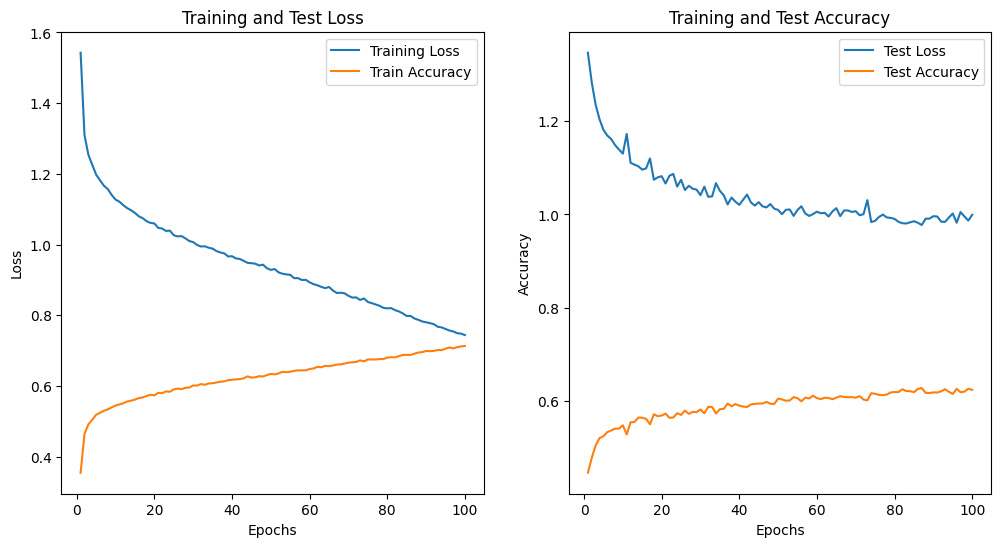

In [ ]:
epochs=100
result = train(epochs=epochs,
      data_loader = train_dataloader,
      model = model,
      loss_fn = loss_fn,
      optimizer = optimizer,
      accuracy_fn = acc_fn,
      device = device)

plot_results(result,epochs)

TODO
1. znalezienie najlepszych parametrów do CNN
2. zapisanie najlepszego modelu (raczej CNN)
3. ewaluacja zewnętrznej próbki (np. nagranie z mikrofonu lub plik audio od 2 do 4 sekund)
